<a href="https://colab.research.google.com/github/wgova/time_series_trade/blob/master/notebooks/data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages

In [ ]:
!pip install -q oec
import oec
import pandas as pd
import numpy as np
import json
from random import sample
import random
import itertools

import os, os.path, csv, requests, pathlib
from datetime import datetime
import math
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
mpl.style.use('ggplot')

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## OEC data API functions

In [ ]:
# Functions adapted from https://github.com/yahiaali/oec for OEC API calls
def build_call(*args):
    call_url = 'http://atlas.media.mit.edu/'
    for val in args:
        call_url += str(val) + '/'
    return call_url


def request_data(call_url):
    r = requests.get(call_url)
    response_dict = r.json()
    json_list = response_dict['data']  # list of dicts containing data
    return json_list


def get_countries(filename=None):
    call = build_call('attr', 'country')
    json_list = request_data(call)
    if filename is not None:
        data_to_csv(json_list, filename)
    return json_list


def get_products(classification, filename=None):
    call = build_call('attr', classification)
    json_list = request_data(call)
    if filename is not None:
        data_to_csv(json_list, filename)
    return json_list


def get_trade(classification, trade_flow, year, origin, destination,product, filename=None):
    call = build_call(classification, trade_flow, year, origin, destination,
                      product)
    json_list = request_data(call)
    if filename is not None:
        data_to_csv(json_list, filename)
    return json_list


def trade_params(classification, trade_flow, year, origin, destination,product):
    parameters = {'classification': classification,
                  'trade_flow': trade_flow,
                  'year': year,
                  'origin': origin,
                  'destination': destination,
                  'product': product}
    return parameters


def get_header(json_list):
    header = set()
    for dict in json_list:
        header.update(dict.keys())
    header = list(header)
    header.sort()
    return header


def create_csv(json_list, filename):
    with open(filename, 'w') as csvfile:
        header = get_header(json_list)
        cw = csv.writer(csvfile)
        cw.writerow(header)
        for dict in json_list:
            row = dict_to_list(dict, header)
            cw.writerow(row)


def dict_to_list(dict, header):
    row = []
    for field in header:
        if field in dict:
            row.append(str(dict[field]))
        else:
            row.append(None)
    return row


### Custom functions
def get_countries_and_products():
  countries = get_countries()
  products = get_products(trade_classification)
  create_csv(countries,f'{PATH}/list_countries.csv')
  create_csv(products,f'{PATH}/list_products.csv')

def download_data(list_of_codes):
  for i in trade_codes:
    csv_name = f"{trade_classification}-{i}"
    # Set parameters to extract top exporters from the API documentation
    params = {'classification': trade_classification,
          'trade_flow': 'export',
          'year': 'all',
          'origin': 'show', #Set origin to all for comparison
          'destination': 'all',
          'product': i} #Set code for product of interest
    print(f'Processing data for {i}.....')
    oec_data = get_trade(**params)
    # Save the results in CSV file
    if path.exists(PATH):
      create_csv(oec_data,f'{csv_name}.csv')
    else:
      print('Choose destination directory')

def create_df(path:str):
  trade_data = [i for i in os.listdir(path) if i.startswith('sitc') and '.csv' in i]
  print(f'List of csv files contentated into one dataframe \n: {list(trade_data)} \n \n')
  trade_history = []
  for file in trade_data:
    file_df = pd.read_csv(os.path.join(path,file))
    trade_history.append(file_df)
  products_dataframe = pd.concat(trade_history)
  return products_dataframe

def underscore_header_names(df):
  '''
  Renaming product names after aggregation with pivot tables
  '''
  df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
  return df.columns


# Generic data processors
def remove_null_values(df,threshold:int=0.8):
  pct_null = df.isnull().sum() / len(df)
  missing_features = pct_null[pct_null > threshold].index
  df.drop(missing_features, axis=1, inplace=True)
  df.fillna(0,inplace=True)

def check_outliers(df):
    col = list(df)
    outliers = pd.DataFrame(columns=['columns','Outliers'])
    
    for column in col:
        if column in df.select_dtypes(include=np.number).columns:
            q1 = df[column].quantile(0.25) 
            q3 = df[column].quantile(0.75)
            below = q1 - (1.5*q3 - q1)
            above = q3 + (1.5*q3 - q1)
            outliers = outliers.append({'columns':column,'Outliers':df.loc[(df[column] < below) | (df[column] > above)].shape[0]},ignore_index=True)
    return outliers
    
def removing_outliers(dataframe):
    cols = list(dataframe)
    for col in cols:
        if col in dataframe.select_dtypes(include=np.number).columns:
            dataframe[col] = winsorize(dataframe[col], limits=[0.1, 0.1],inclusive=(True, True))
    
    return dataframe

## Generate dataset
- OEC API endpoint down as at 16 June 2020

- This data has been downloaded and saved in the folder indicated
No need to run this if there no new data needed
- [Resource on nicer sns and plt plots](https://www.drawingfromdata.com/setting-figure-size-using-seaborn-and-matplotlib)


In [ ]:
# Generate lists for countries and products
PATH = '/content/drive/My Drive/Stellenbosch/Webster'
trade_classification = 'sitc'
# get_countries_and_products()
trade_codes = ['6519','6531','8471','6571','7849','7810','7842','7764',
               '7723','7522','2924','5419','5417','7763','7711','7188']
# download_data(trade_codes)
# Load trade data
include_list = ['year','origin_id','sitc_id','export_val']
trade_data = create_df(PATH)
trade_df = trade_data[include_list]

# Load country names
country_list = pd.read_csv(f'{PATH}/list_countries.csv',usecols=['id','name'],
                        na_values='',na_filter=True)
country_list.rename(columns=lambda x: x.replace('name','country'), inplace=True)
country_list.rename(columns=lambda x: x.replace('id','origin_id'), inplace=True)

# Update country names
trade_dframe = trade_df.merge(country_list, on=['origin_id'],how='inner')
trade_dframe['sitc_id'].astype('category')
trade_dframe.fillna(0,inplace=True)

# Load product list
products = pd.read_csv(f'{PATH}/list_products.csv',usecols=['id','name','display_id'])
products.rename(columns={'id':'sitc_id'},inplace=True)
products = products[products['display_id'].isin(trade_codes)]
products['name'] = products.name.astype('category')

# Update product names in dataframe
products['sitc_id'] = products.sitc_id.astype(int)
trade_dframe['product_name'] = trade_dframe.sitc_id\
.map(products.set_index('sitc_id')['name'].to_dict())

# Rename long product names
dict_of_name_options = {'Yarn of Textile Fibers':'yarn_fiber',
             'Synthetic Woven Fabrics':'synthetic_fiber',
             'Textile Fabrics Clothing Accessories':'accessory_fabrics',
             'Vehicles Parts and Accessories':'vehicle_parts',
             'Personal Computers':'computers',
             'Pharmaceutical Flora':'pharma_flora',
             'Non-Medicinal Pharmaceutical Products':'non_medicinals',
             'Diodes, Transistors and Photocells':'diodes_transistors_photocells',
             'Miscellaneous Engines':'engines_misc'
             }
trade_dframe['product_name']= trade_dframe['product_name'].map(
    dict_of_name_options)\
    .fillna(trade_dframe['product_name'])

# Remove unspecified country names included in the list  
unknown_origin_list = {'Areas',
                       'United States Unspecified',
                       'Northern Africa',
                       'Other Africa Not Elsewhere Specified',
                       'Europe Other Not Elsewhere Specified',
                       'European Union Not Elsewhere Specified',
                       'Neutral Zone'}
trade_dframe = trade_dframe[~trade_dframe['country'].isin(unknown_origin_list)]
trade_dframe['year'] = pd.to_datetime(trade_dframe['year'],format='%Y')
trade_dframe['year'] = trade_dframe['year'].dt.year

# Checking for countries with 'x' in origin_id
s = trade_dframe['origin_id'].astype(str)
x_country = list(s[s.str.contains('x')].unique())
unspecified = trade_dframe[trade_dframe['origin_id'].isin(x_country)]
print(f'\n Checking if countries to exclude is successful : \n {unspecified["country"].unique()}')

# from datetime import datetime
# # trade_dframe['year'].astype('datetime64[ns]')
# # df['Time stamp'] = pd.to_datetime(df['Time stamp'].str.strip(), format='%d/%m/%Y')
trade_dframe.head()

List of csv files contentated into one dataframe 
: ['sitc-6519.csv', 'sitc-6531.csv', 'sitc-7842.csv', 'sitc-8471.csv', 'sitc-7764.csv', 'sitc-6571.csv', 'sitc-7723.csv', 'sitc-7522.csv', 'sitc-7849.csv', 'sitc-5417.csv', 'sitc-7810.csv', 'sitc-2924.csv', 'sitc-7763.csv', 'sitc-7711.csv', 'sitc-5419.csv', 'sitc-7188.csv'] 
 


 Checking if countries to exclude is successful : 
 ['Mexico' 'Other Asia' 'Saint Kitts, Nevis and Anguilla'
 'Christmas Island' 'China Free Trade Zone (FTZ)' 'Belgium-Luxembourg'
 'Luxembourg' 'Oceania' 'British Antarctic Territory']


year origin_id  sitc_id  export_val        country product_name
0  1962     afciv   606519      3000.0  Cote d'Ivoire   yarn_fiber
1  1963     afciv   606519     15000.0  Cote d'Ivoire   yarn_fiber
2  1964     afciv   606519      4000.0  Cote d'Ivoire   yarn_fiber
3  1966     afciv   606519      2000.0  Cote d'Ivoire   yarn_fiber
4  1967     afciv   606519      7000.0  Cote d'Ivoire   yarn_fiber

## Plots from pivot table aggregates
* Random country South africa
* Country trade basket
* Export comparison for countries (random country examples)
* [Link to presentation: ](https://docs.google.com/presentation/d/1tR2p-pcJcCsv_8f3Ee6oT_X4imdrwVrzvOpIFr04LWg/edit?usp=sharing)

In [ ]:
random.seed(20)
c = str(sample(list(trade_dframe['country'].unique()), 1)[0])
agg_south_africa = pd.pivot_table(trade_dframe[trade_dframe.country=='South Africa'], index='year', columns='product_name', values='export_val', aggfunc=np.mean)
agg_south_africa.fillna(0,inplace=True)
underscore_header_names(agg_south_africa)

# https://pbpython.com/pandas-pivot-table-explained.html
agg_product = pd.pivot_table(trade_dframe, index='year', columns='product_name', values='export_val', aggfunc=np.mean)
remove_null_values(agg_product)
underscore_header_names(agg_product)

agg_country = pd.pivot_table(trade_dframe, index='year', columns='country', values='export_val', aggfunc=np.mean)
remove_null_values(agg_country)

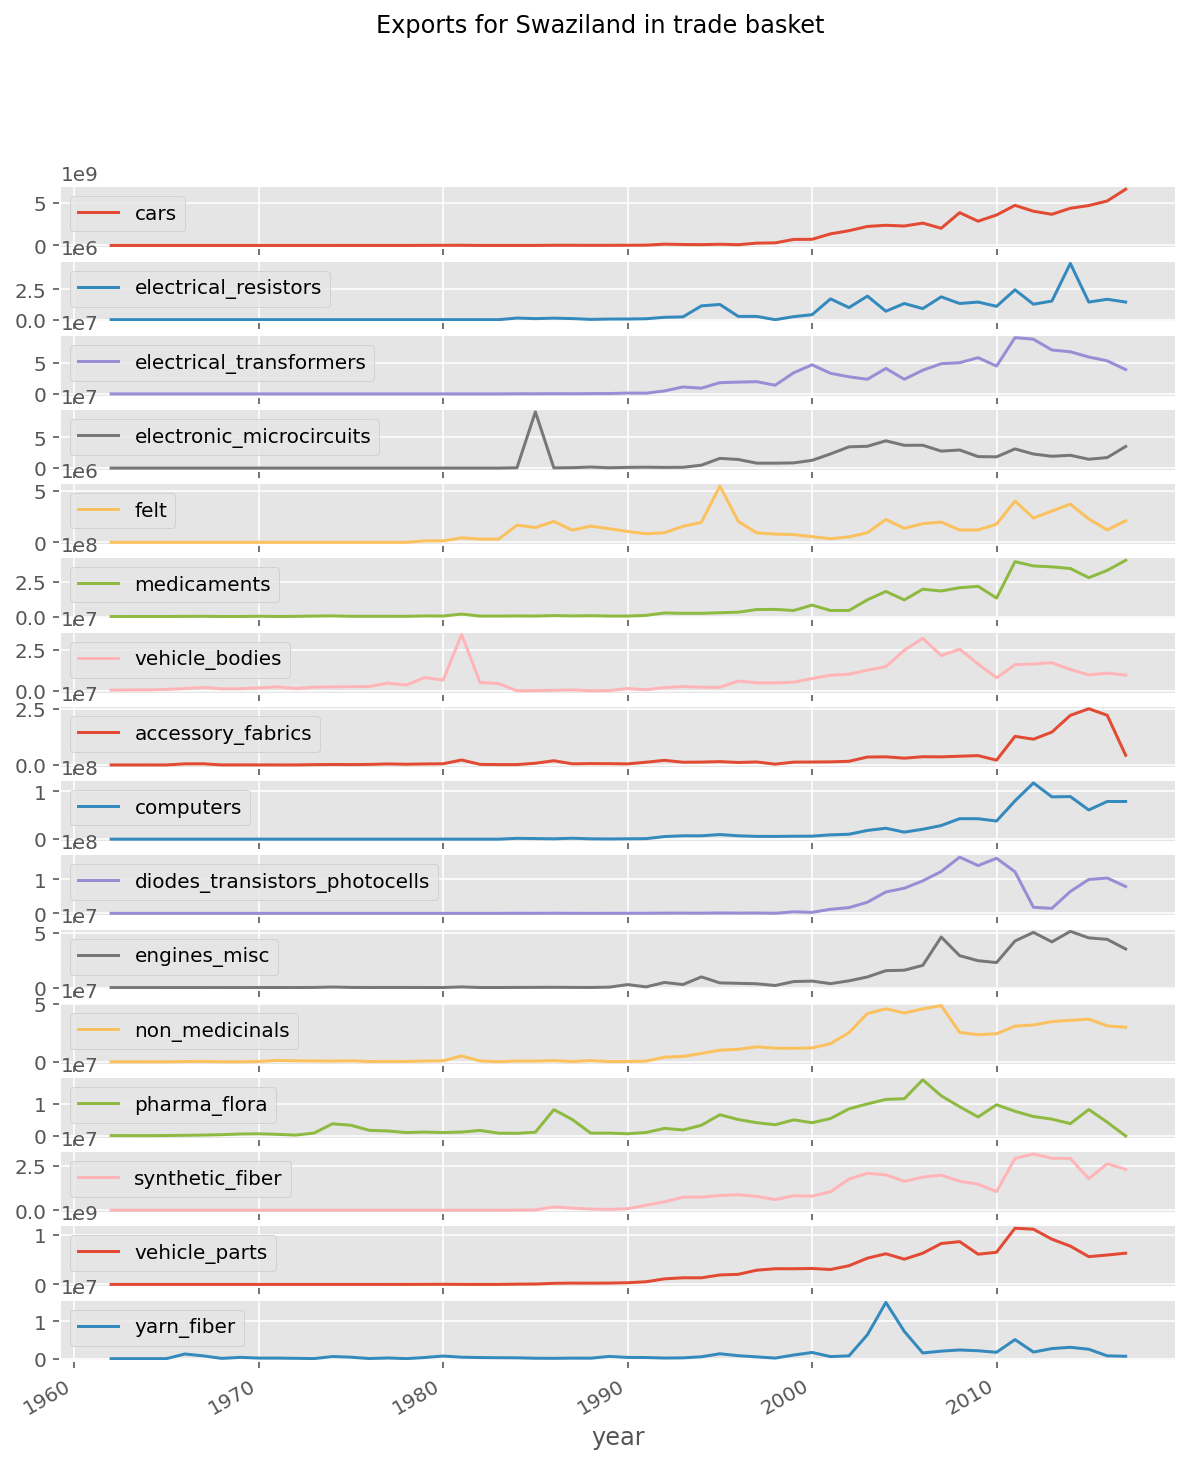

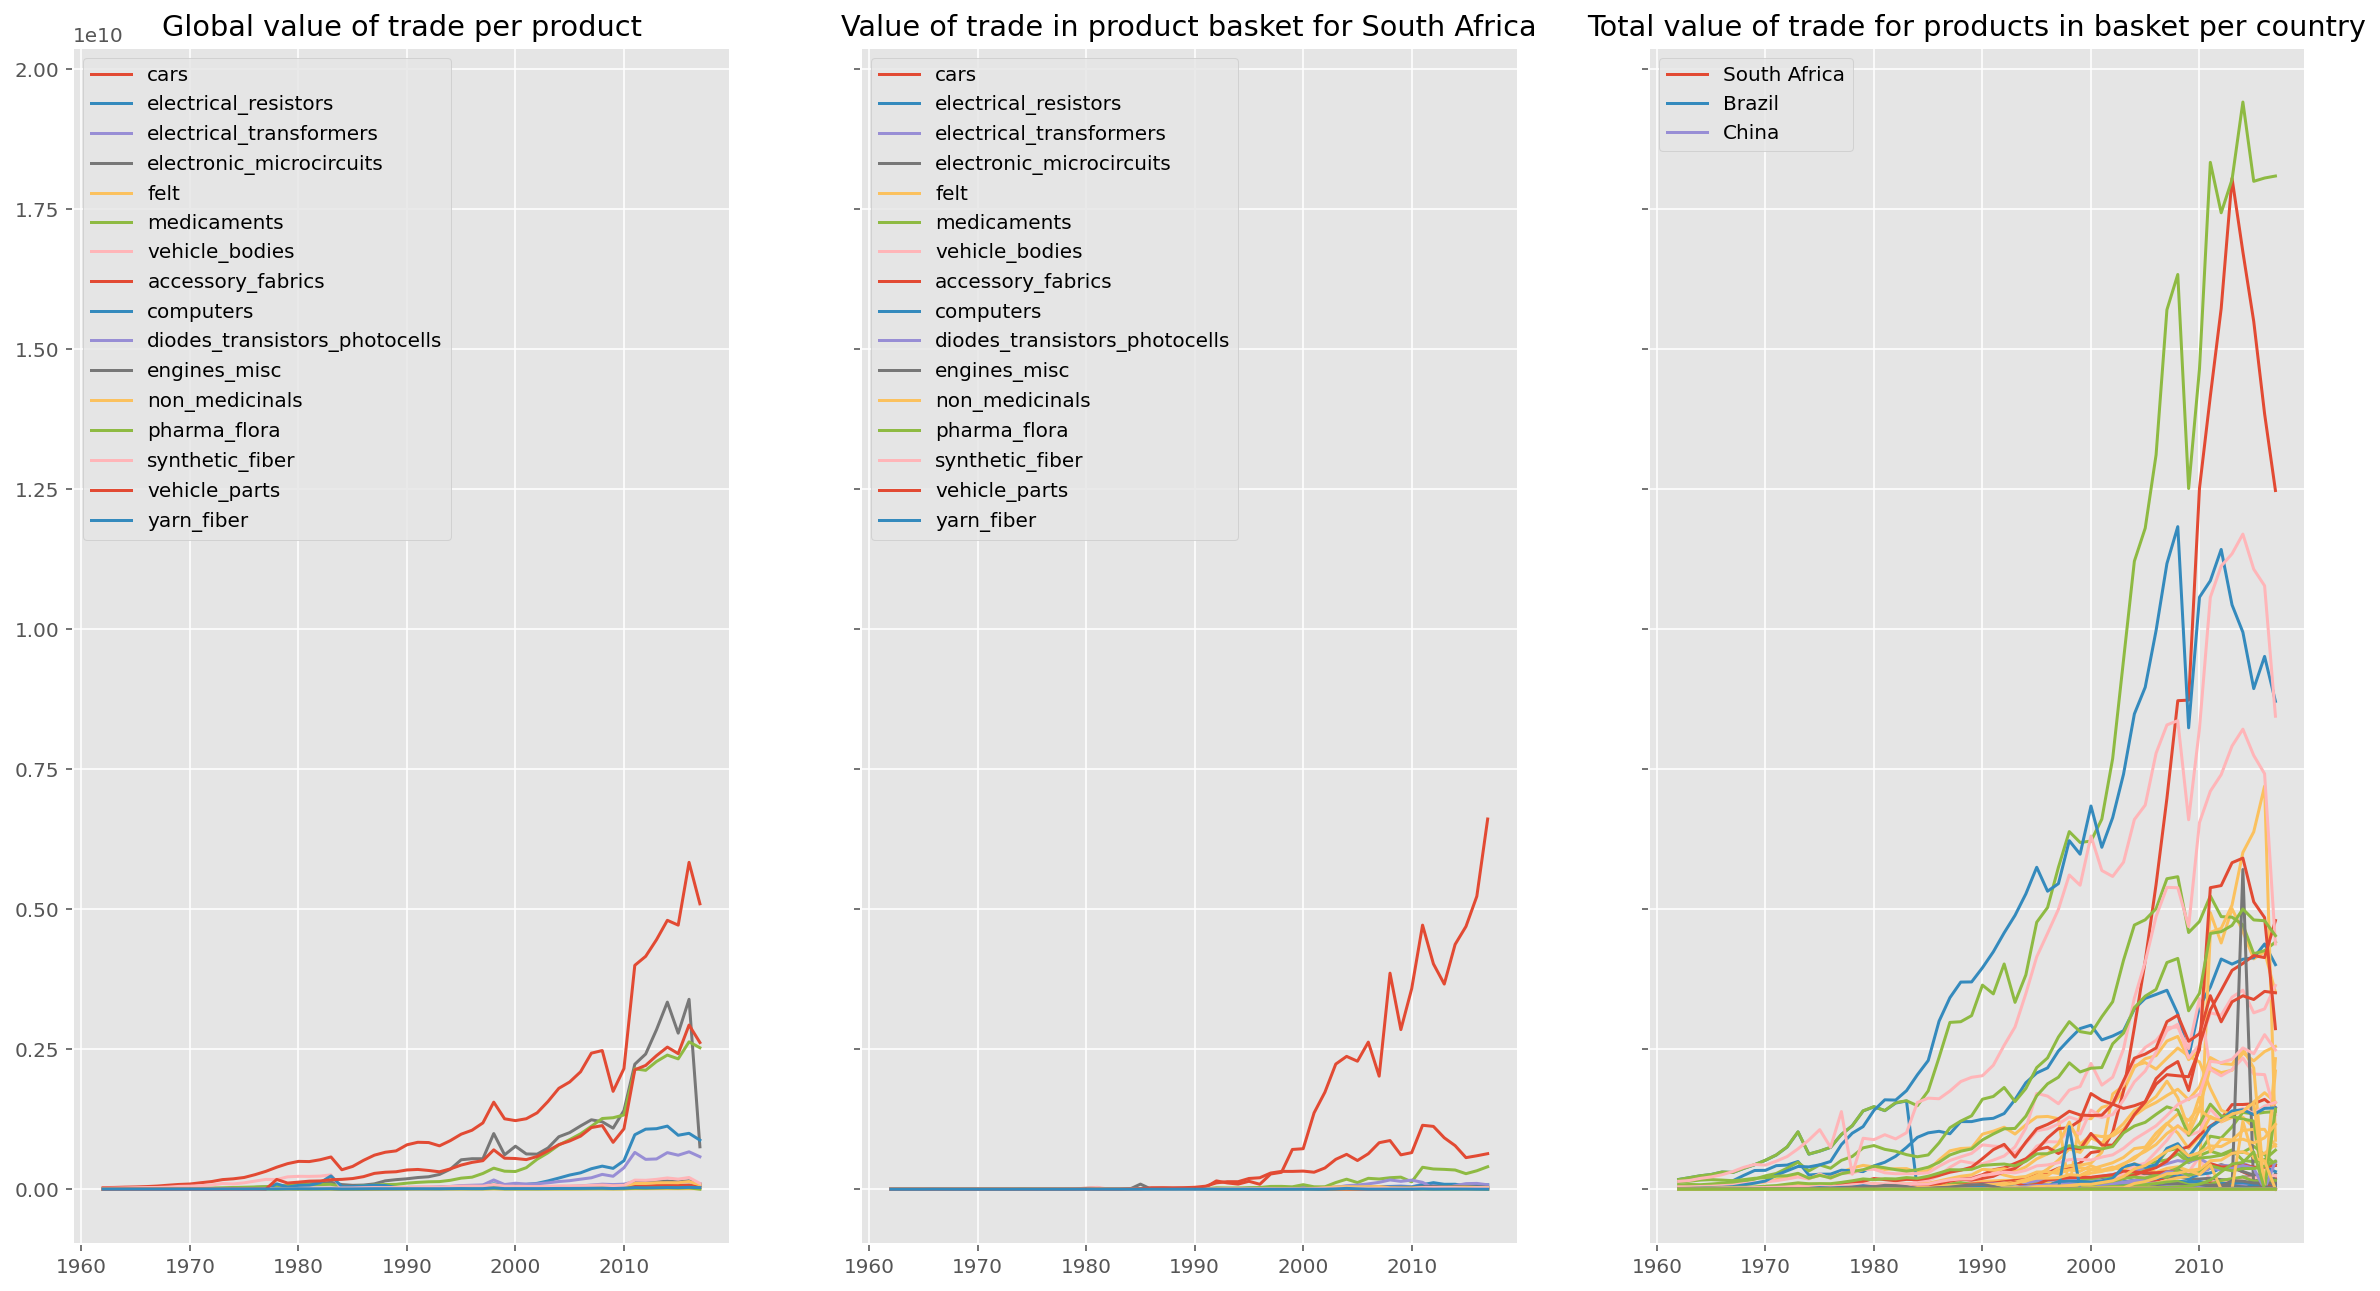

In [ ]:
agg_south_africa.plot(subplots=True,figsize=(10, 12),title=f"Exports for {c} in trade basket",sharey=False)
plt.savefig(f"{PATH}/images/raw_south_africa")
plt.show()

fig, ((ax1, ax2,ax3)) = plt.subplots(nrows=1, ncols=3,sharey=True,figsize=(20, 11))

ax1.plot(agg_product)
ax1.title.set_text("Global value of trade per product")
ax1.legend(agg_product.columns,loc="upper left")

ax2.plot(agg_south_africa)
ax2.title.set_text("Value of trade in product basket for South Africa")
ax2.legend(agg_south_africa.columns,loc="upper left")

ax3.plot(agg_country)
ax3.title.set_text("Total value of trade for products in basket per country")
ax3.legend(['South Africa','Brazil','China'],loc="upper left")
# plt.plot(agg_south_africa,'--')
plt.savefig(f"{PATH}/images/global_overview_raw")
plt.show()

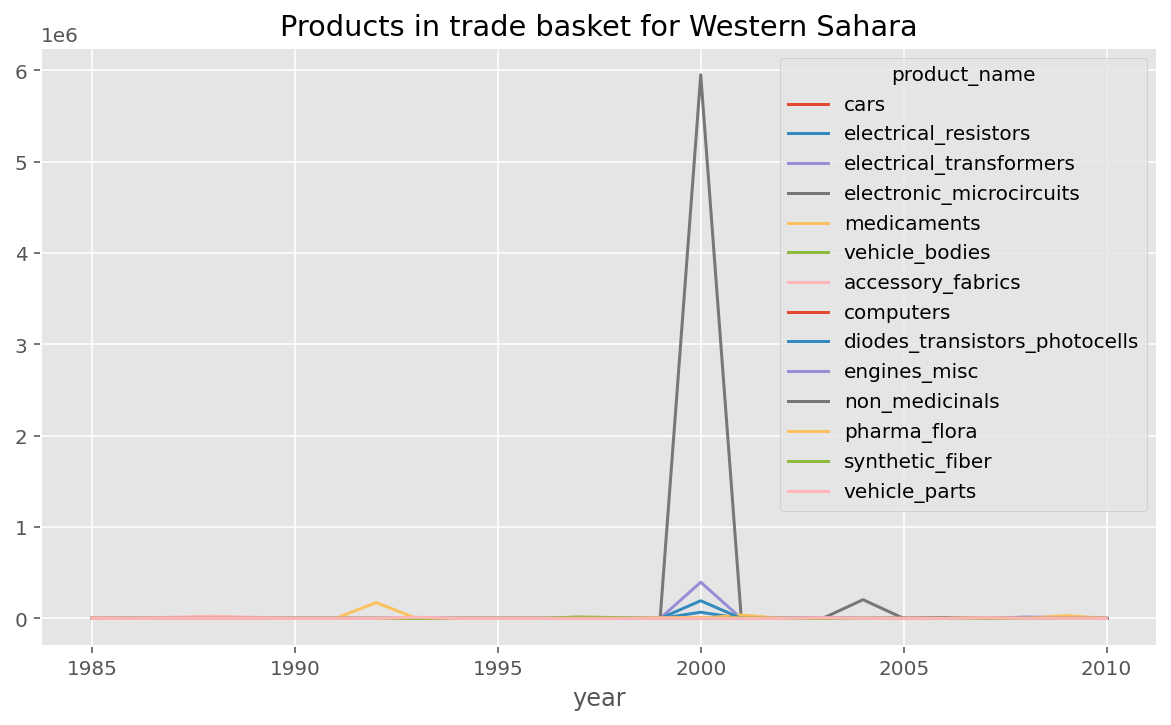

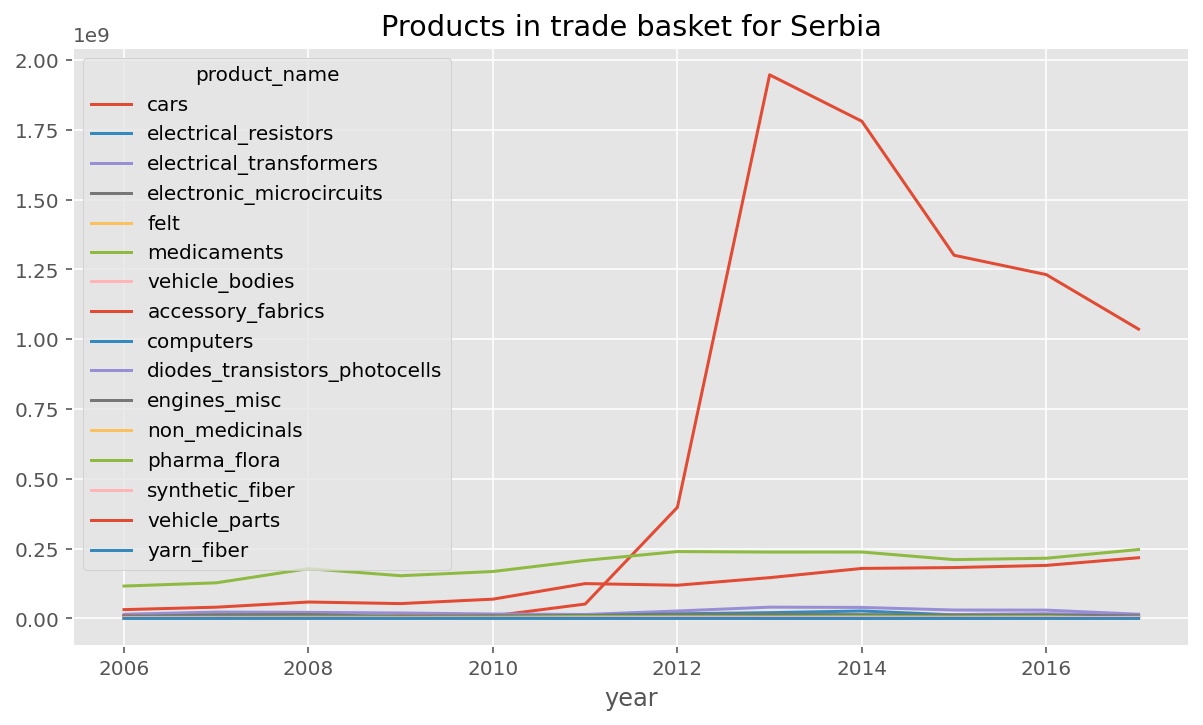

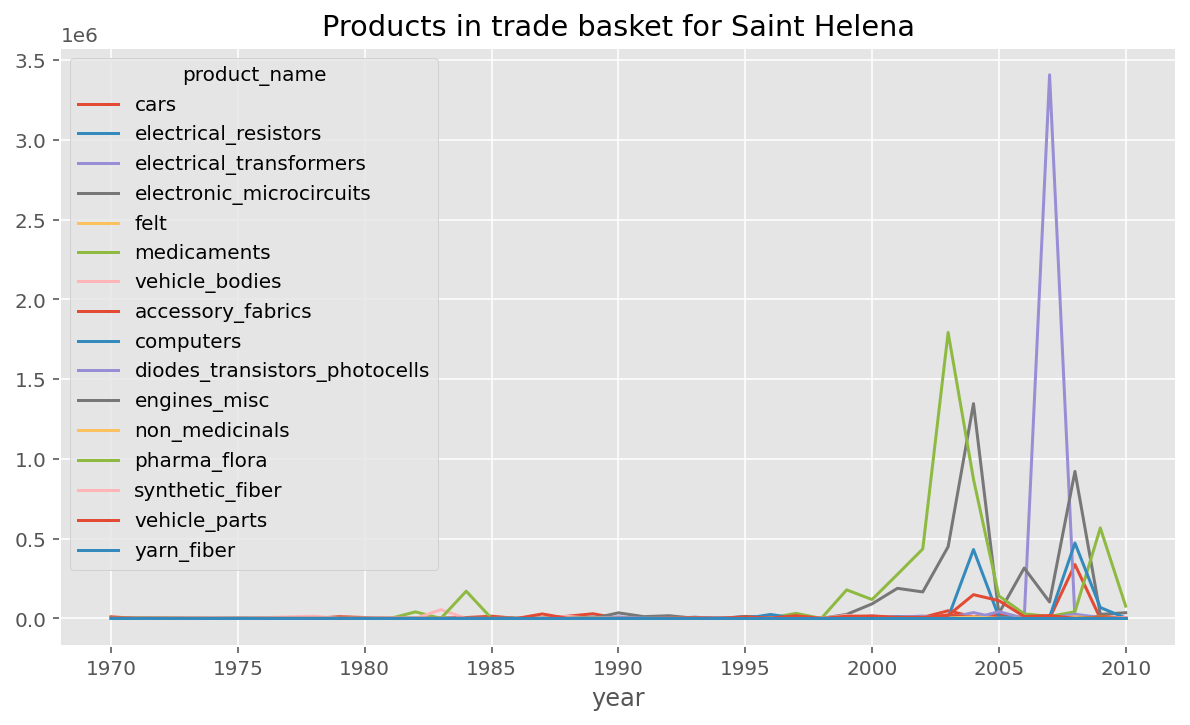

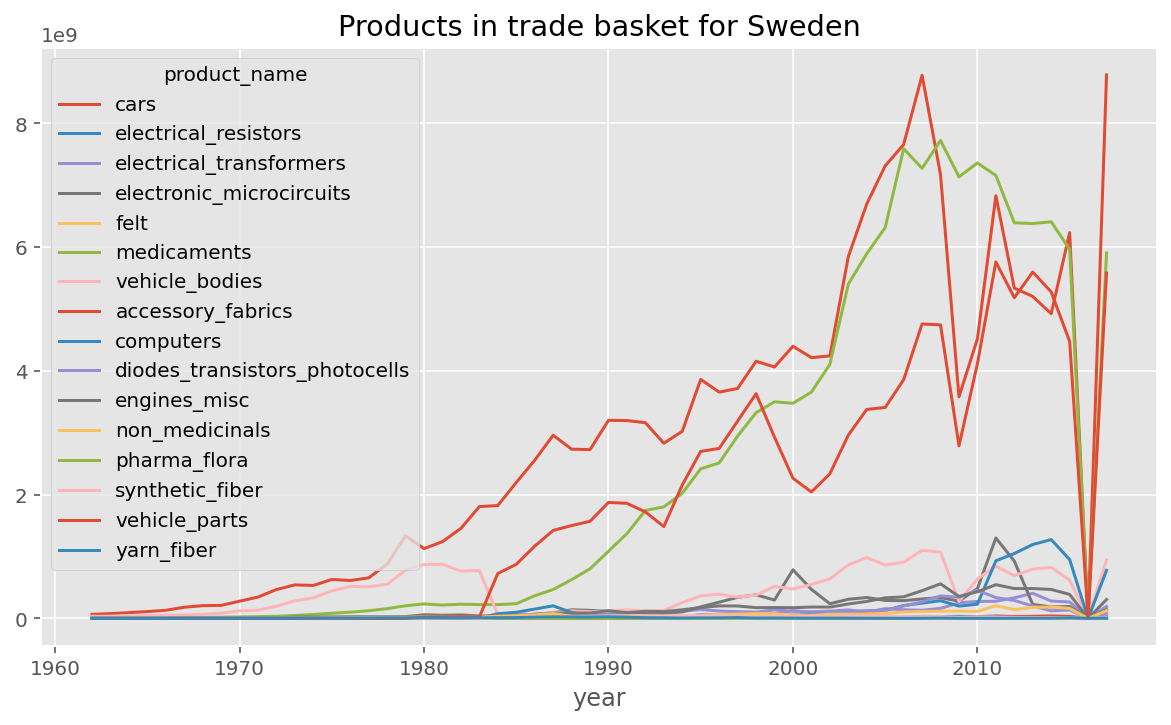

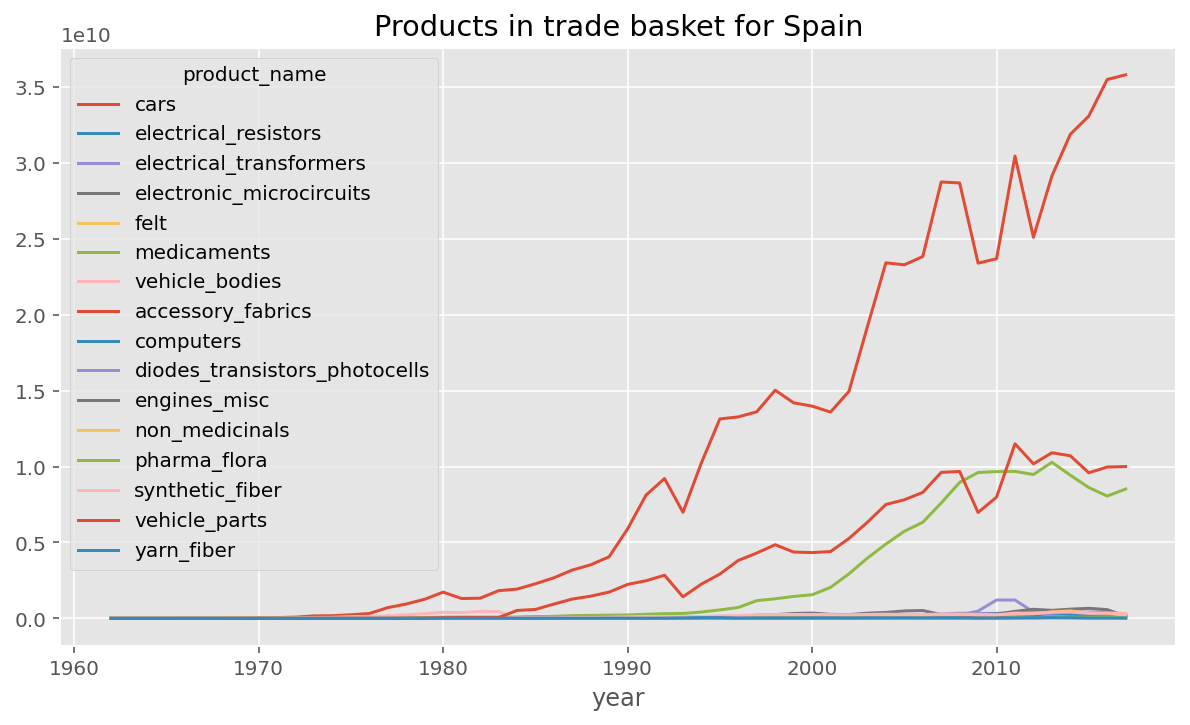

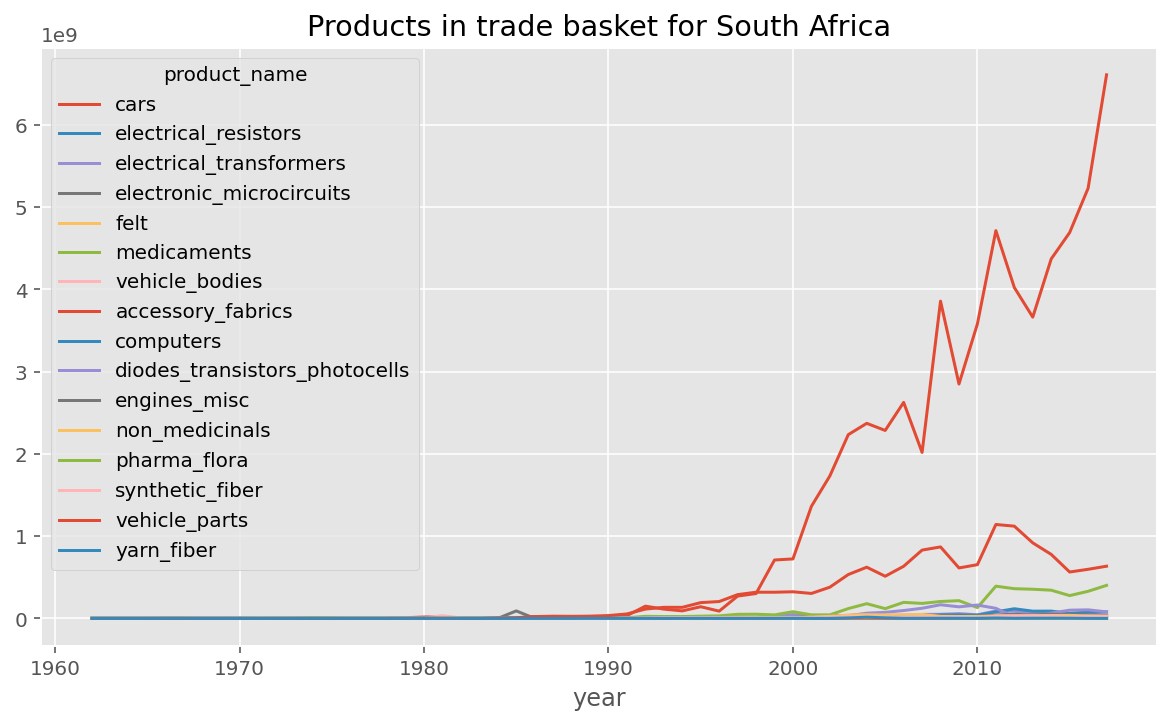

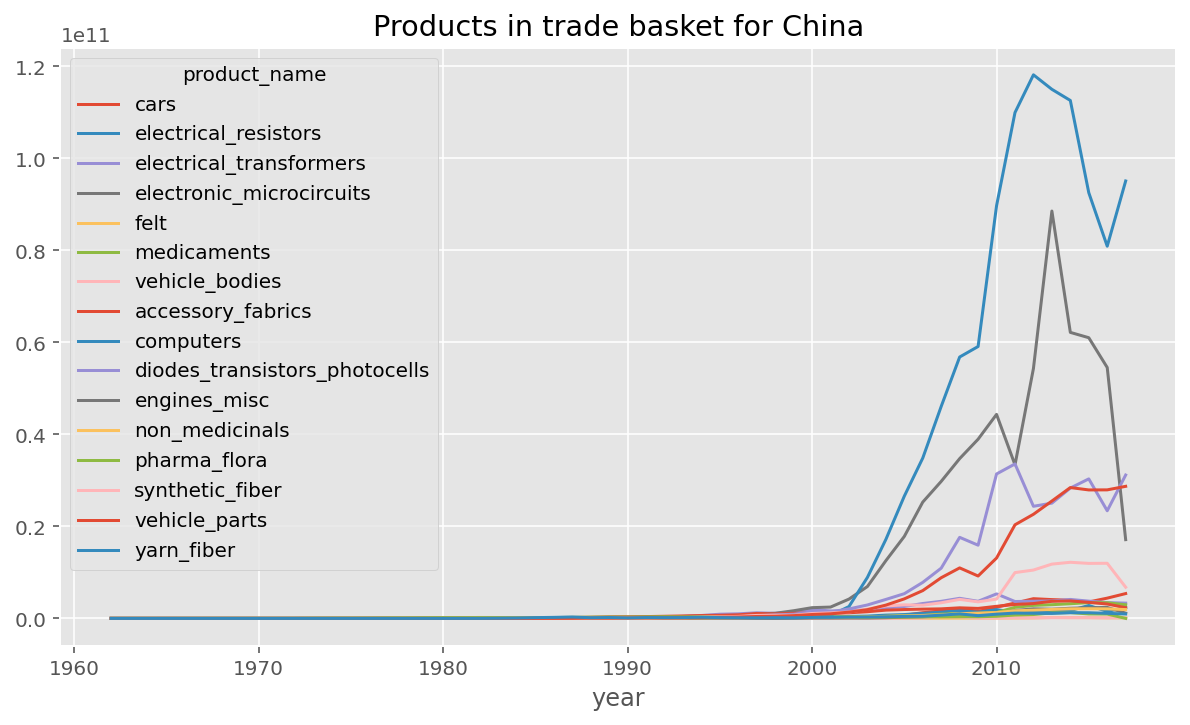

<Figure size 720x396 with 0 Axes>

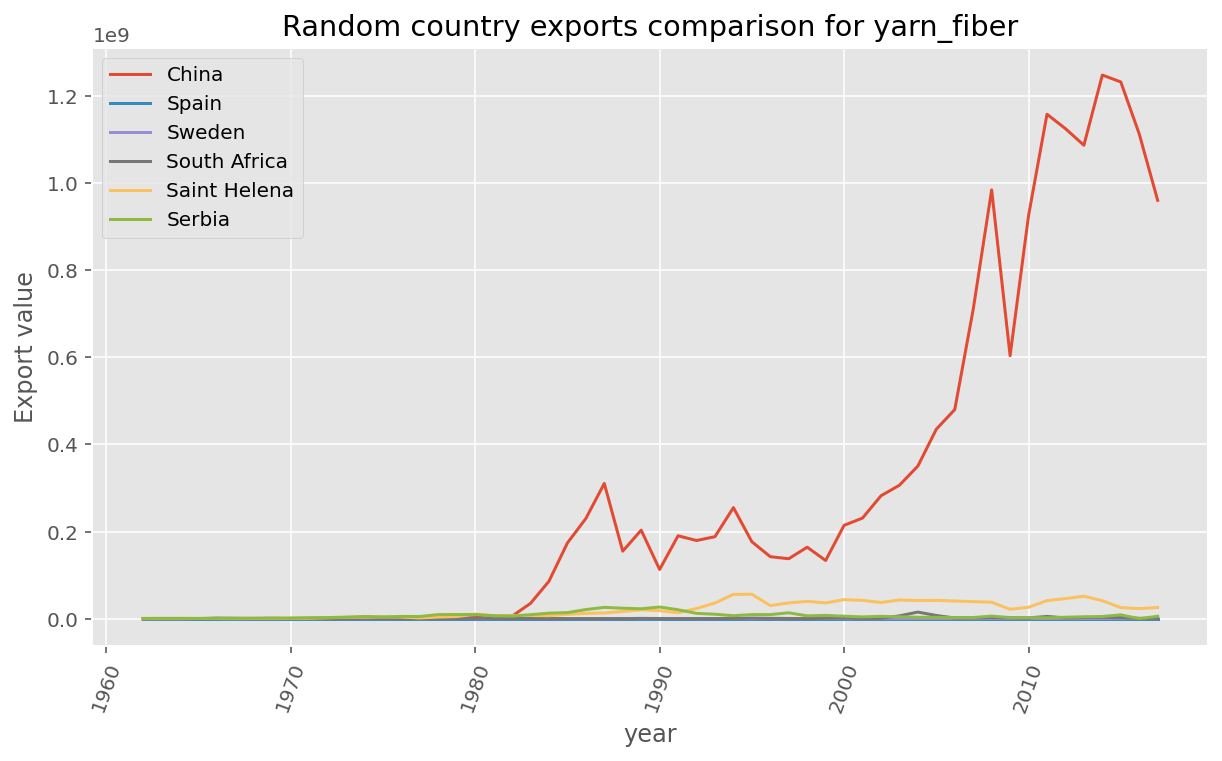

<Figure size 720x396 with 0 Axes>

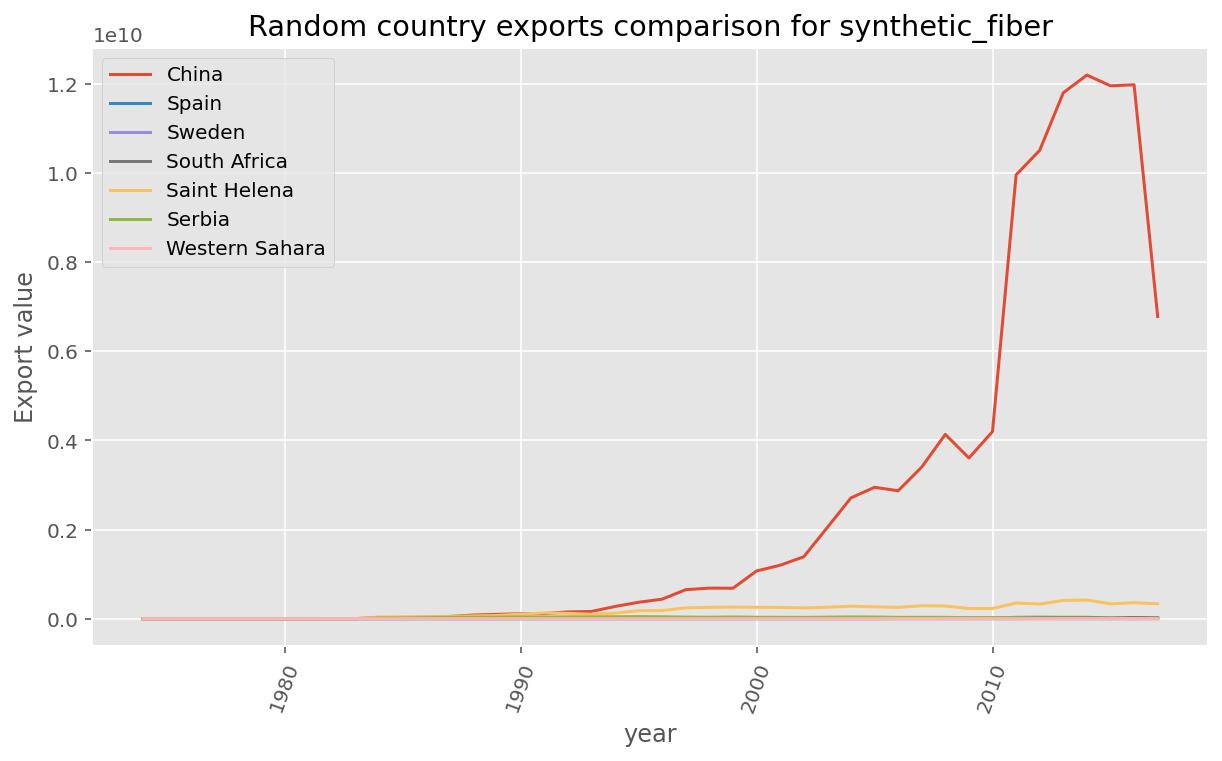

<Figure size 720x396 with 0 Axes>

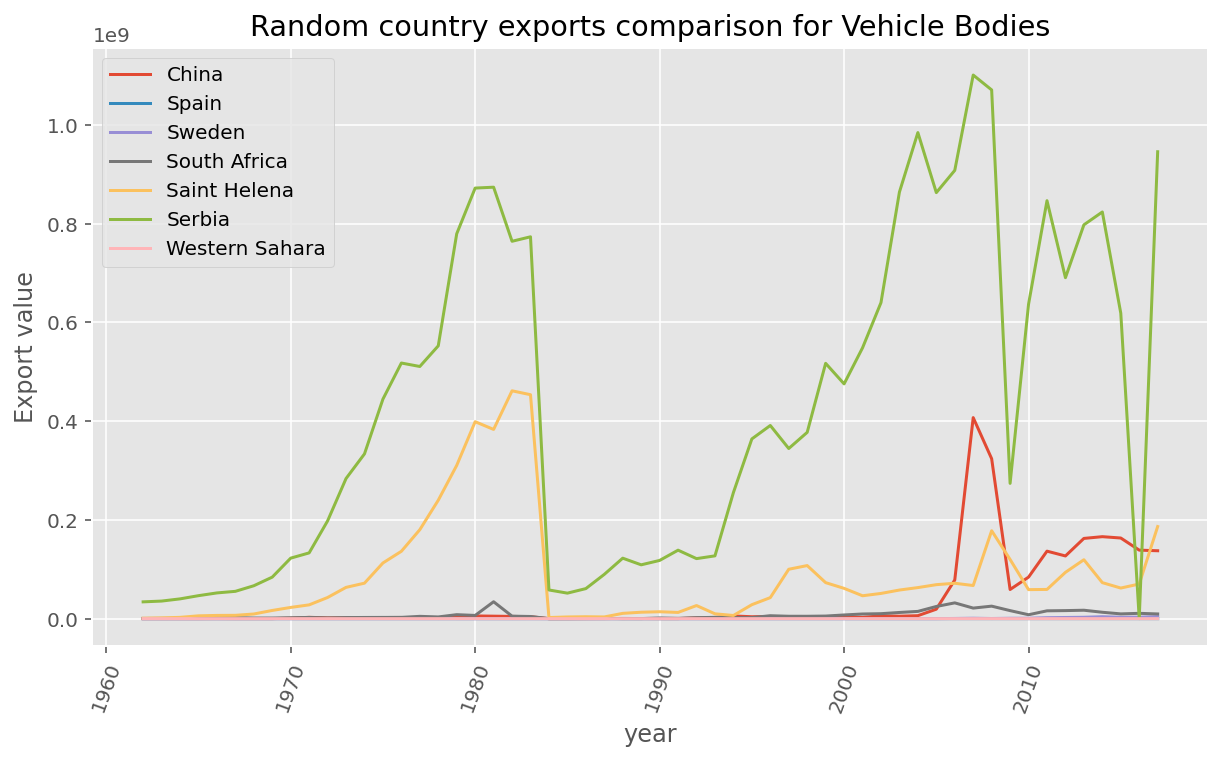

<Figure size 720x396 with 0 Axes>

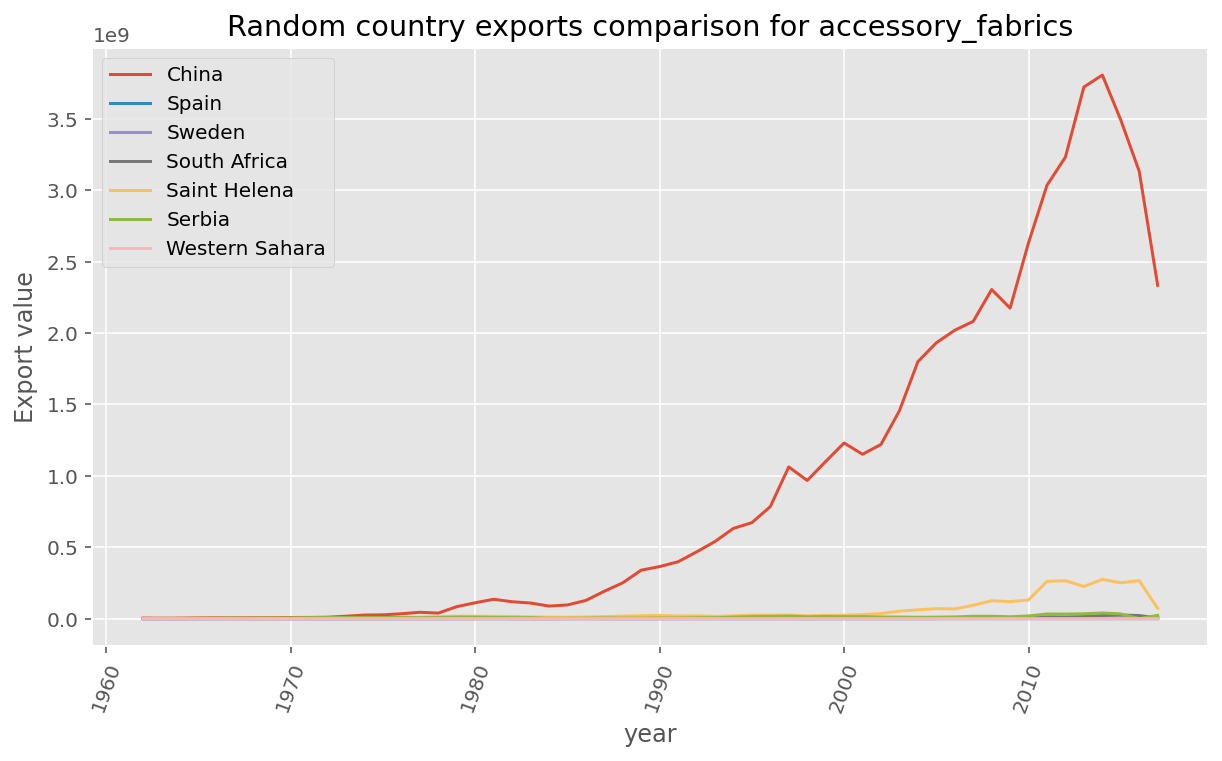

<Figure size 720x396 with 0 Axes>

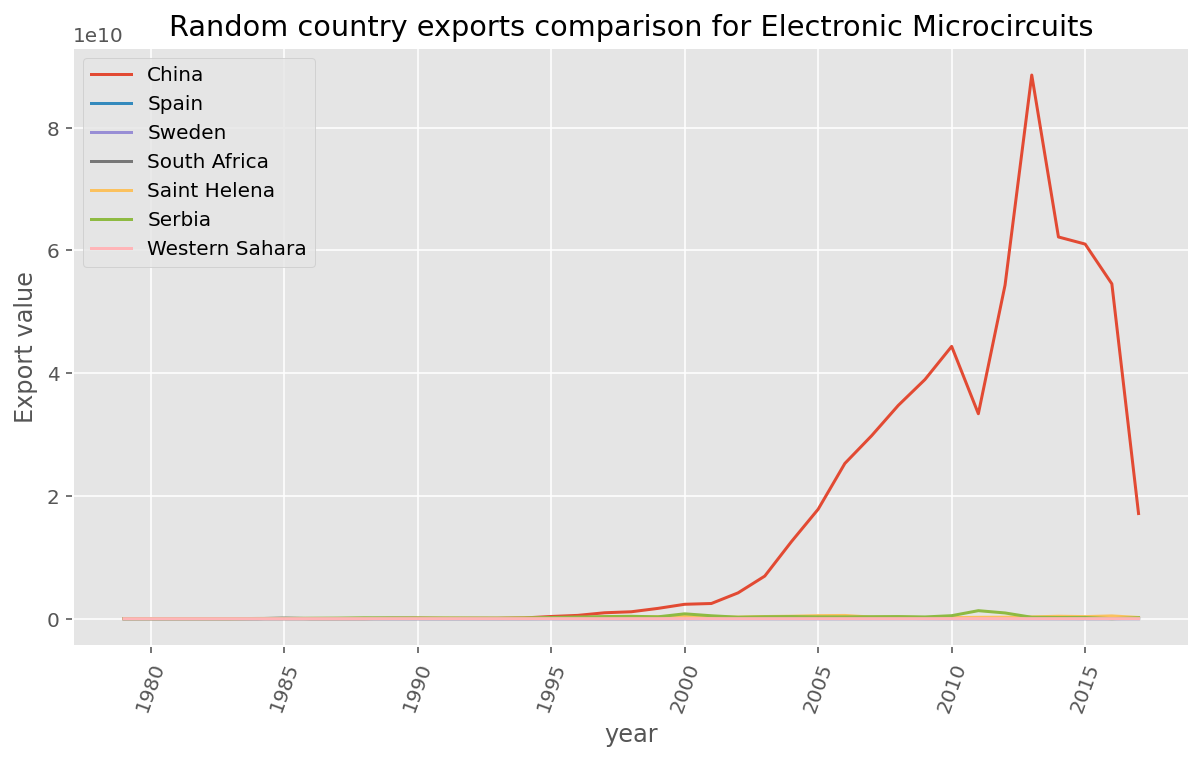

<Figure size 720x396 with 0 Axes>

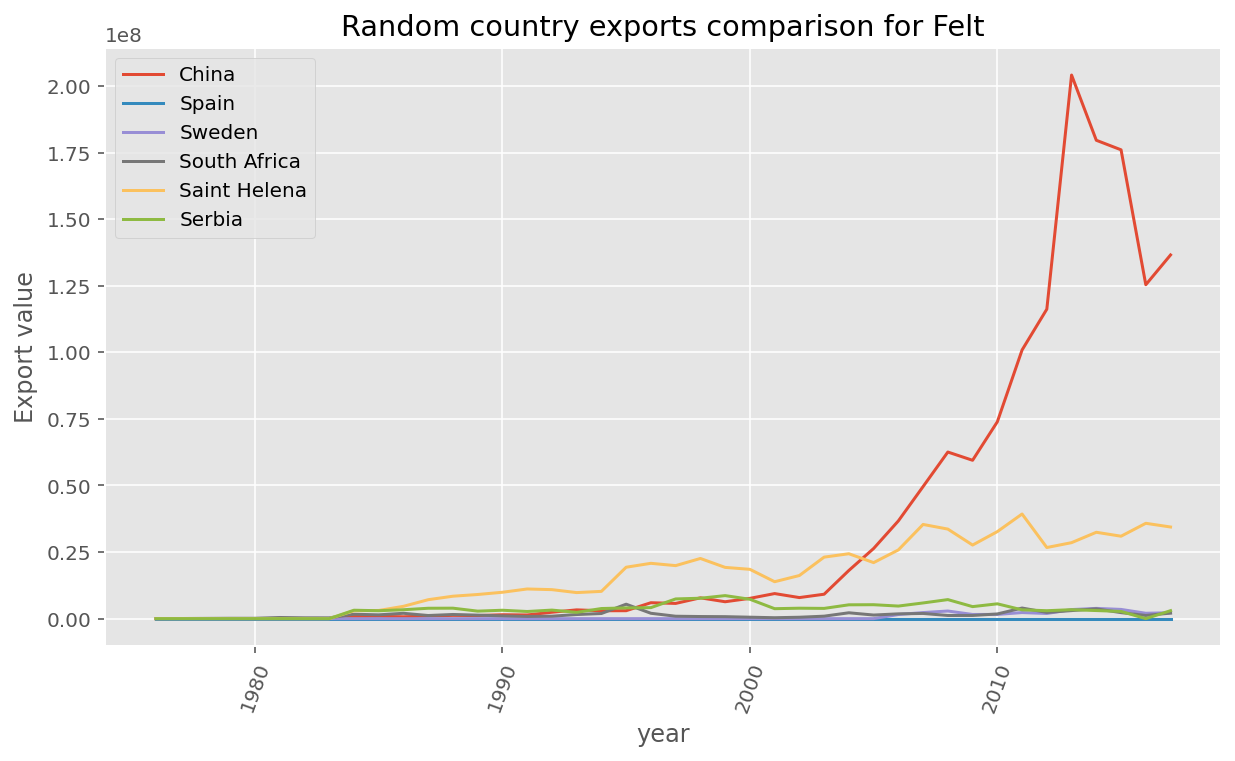

<Figure size 720x396 with 0 Axes>

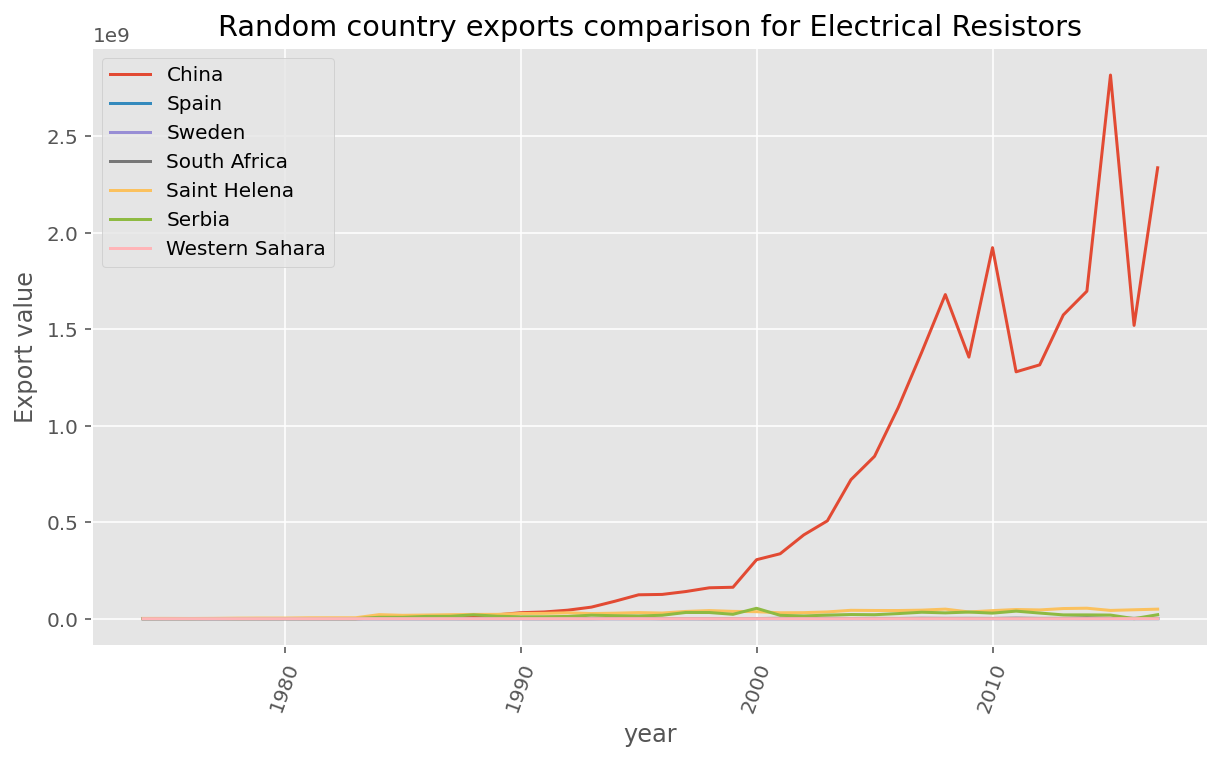

<Figure size 720x396 with 0 Axes>

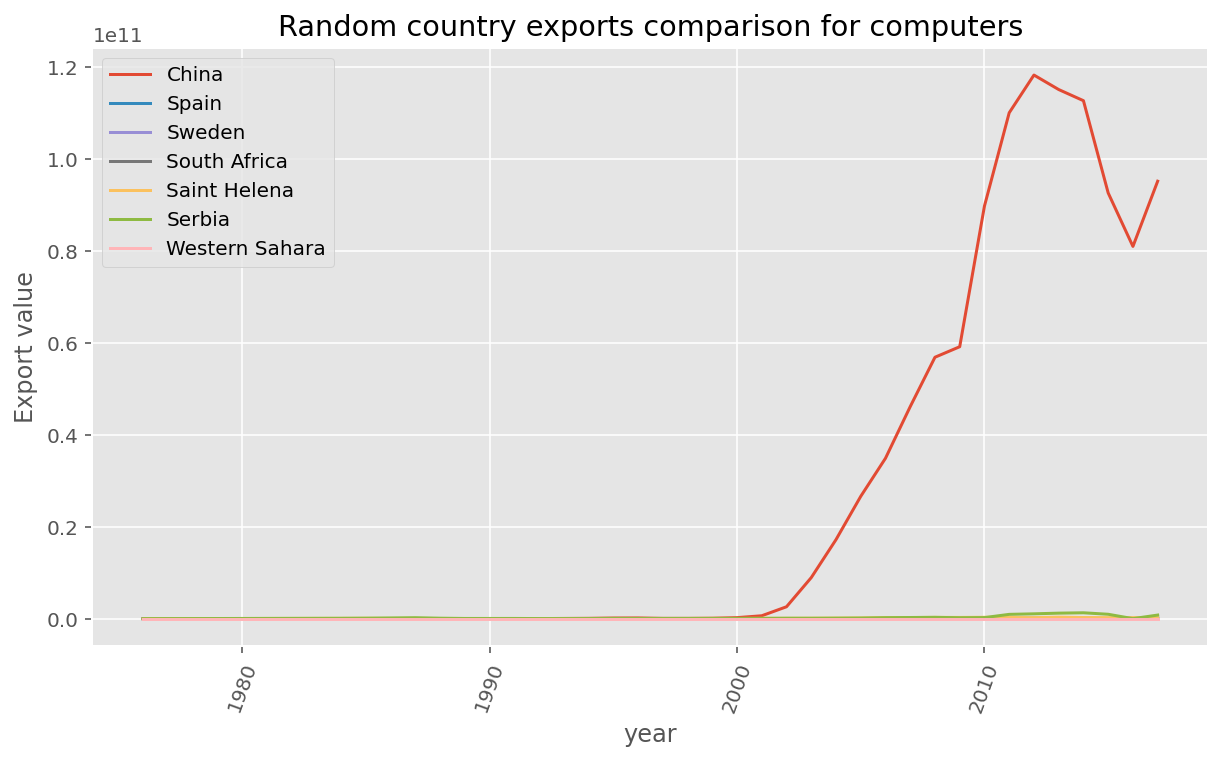

<Figure size 720x396 with 0 Axes>

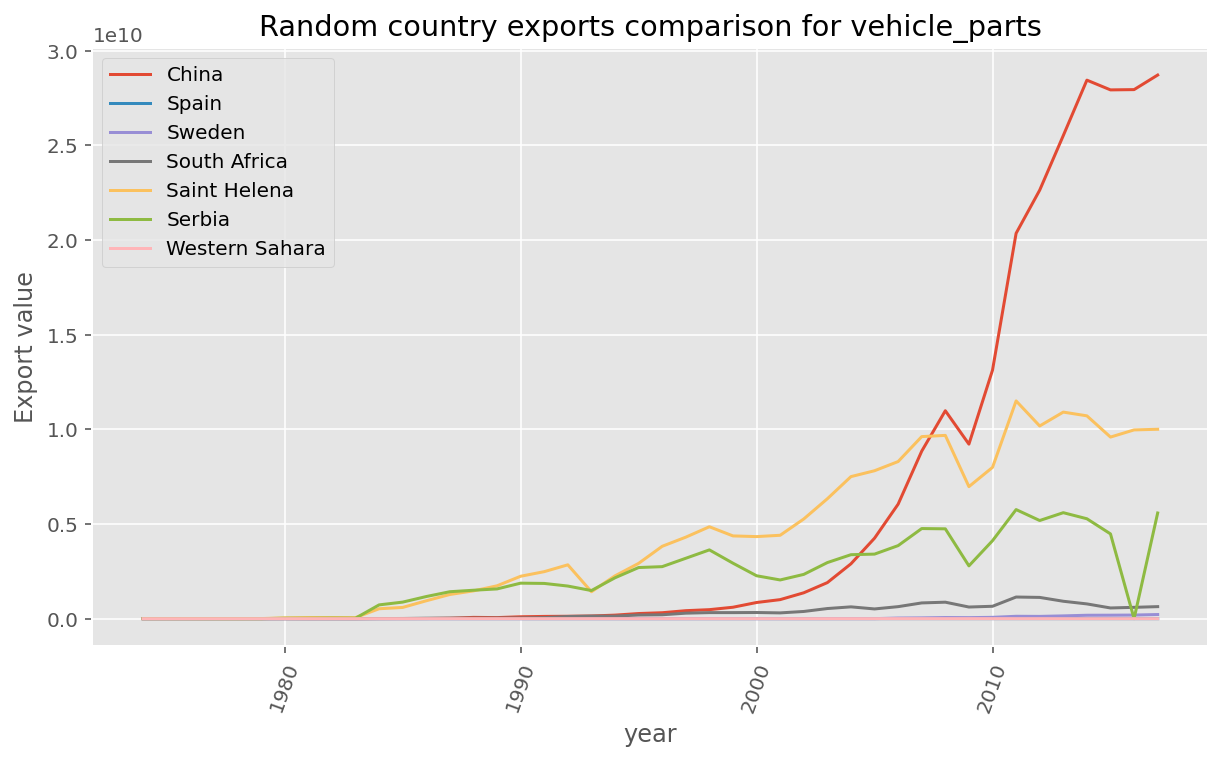

<Figure size 720x396 with 0 Axes>

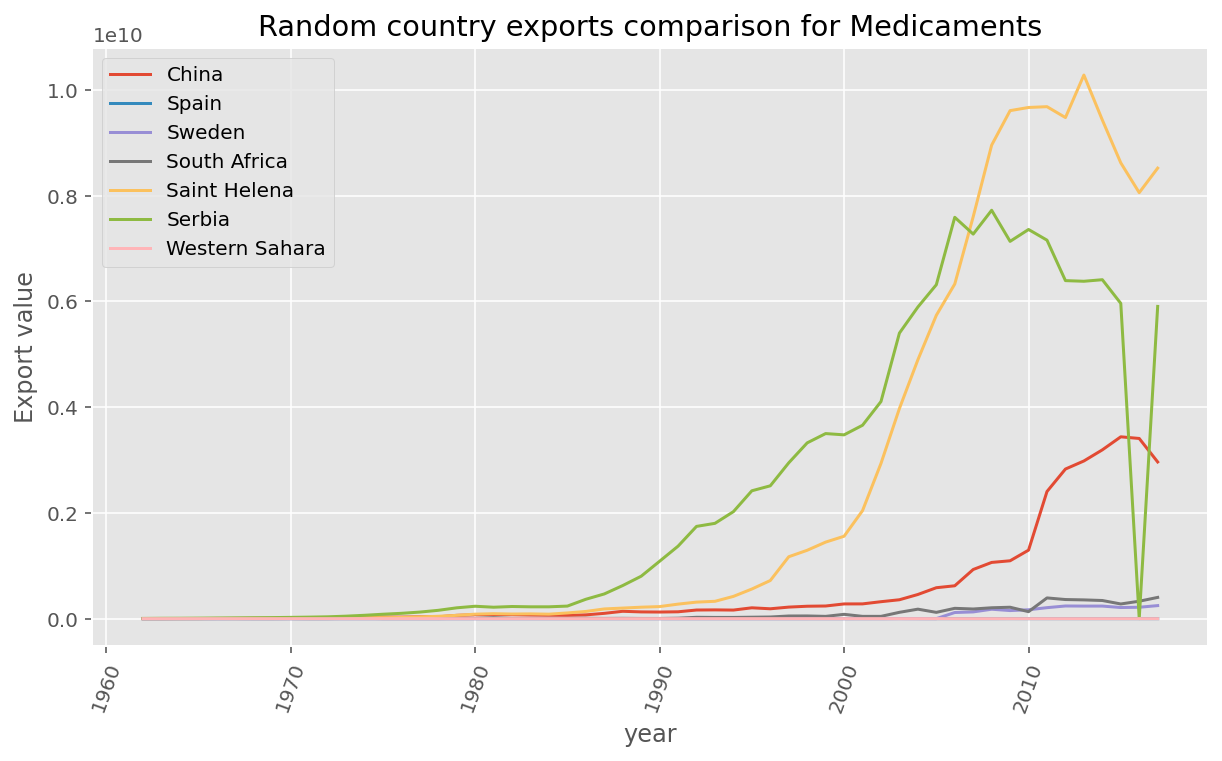

<Figure size 720x396 with 0 Axes>

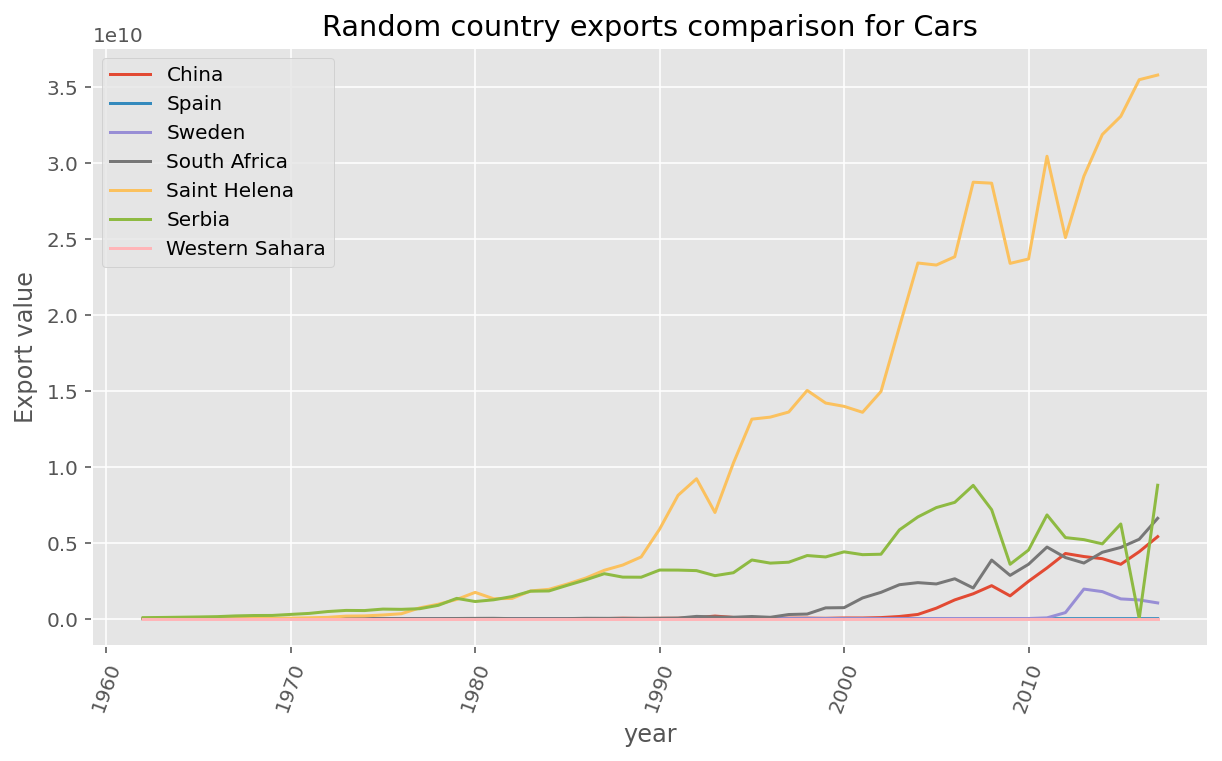

<Figure size 720x396 with 0 Axes>

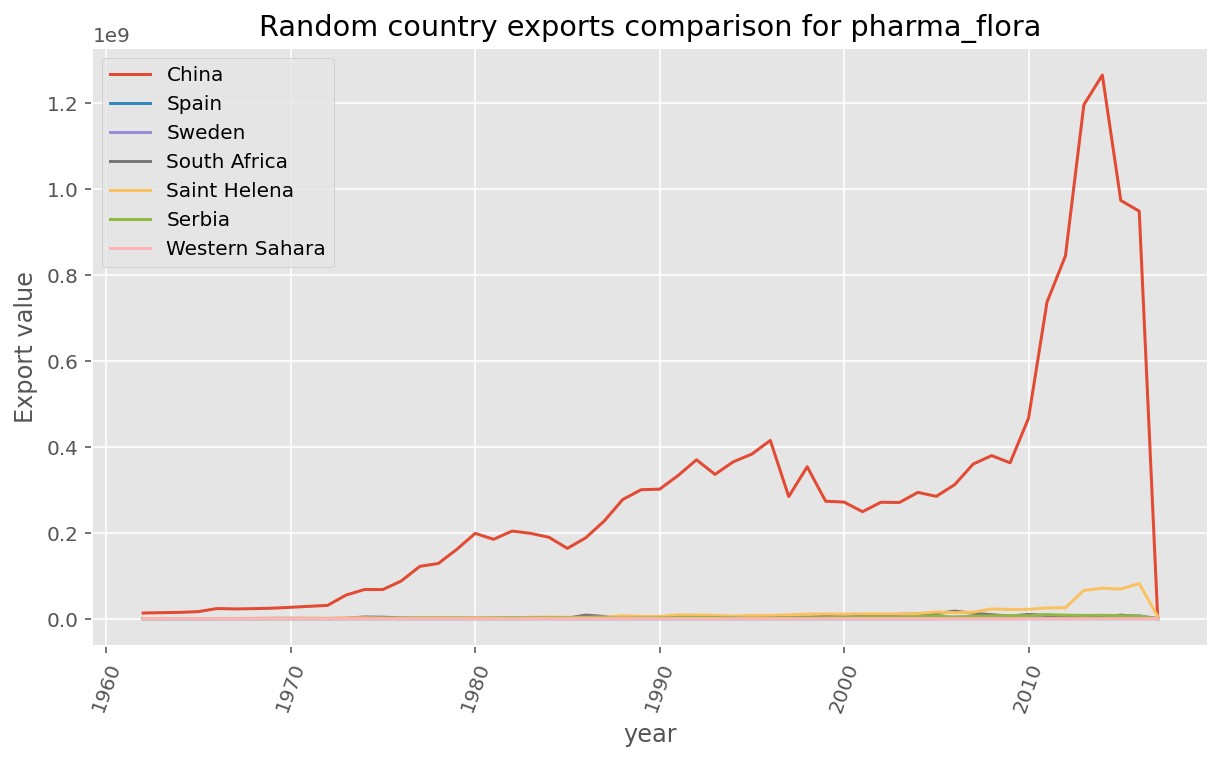

<Figure size 720x396 with 0 Axes>

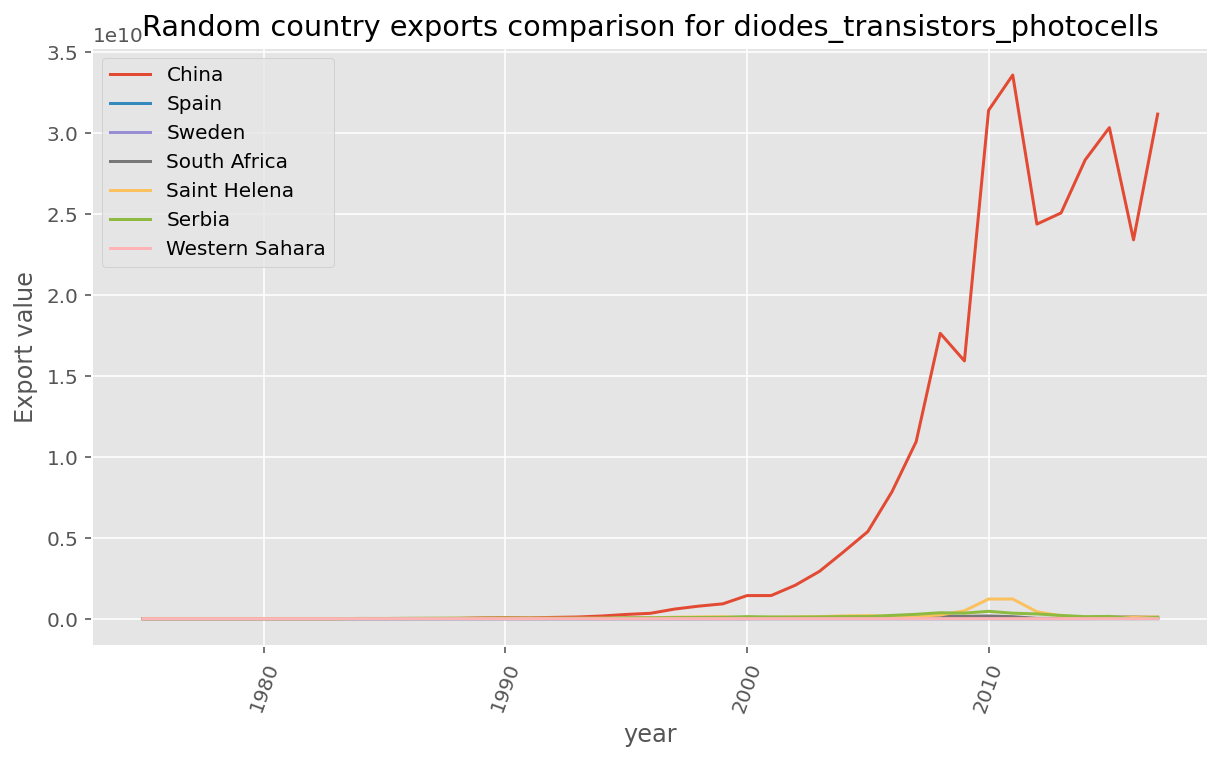

<Figure size 720x396 with 0 Axes>

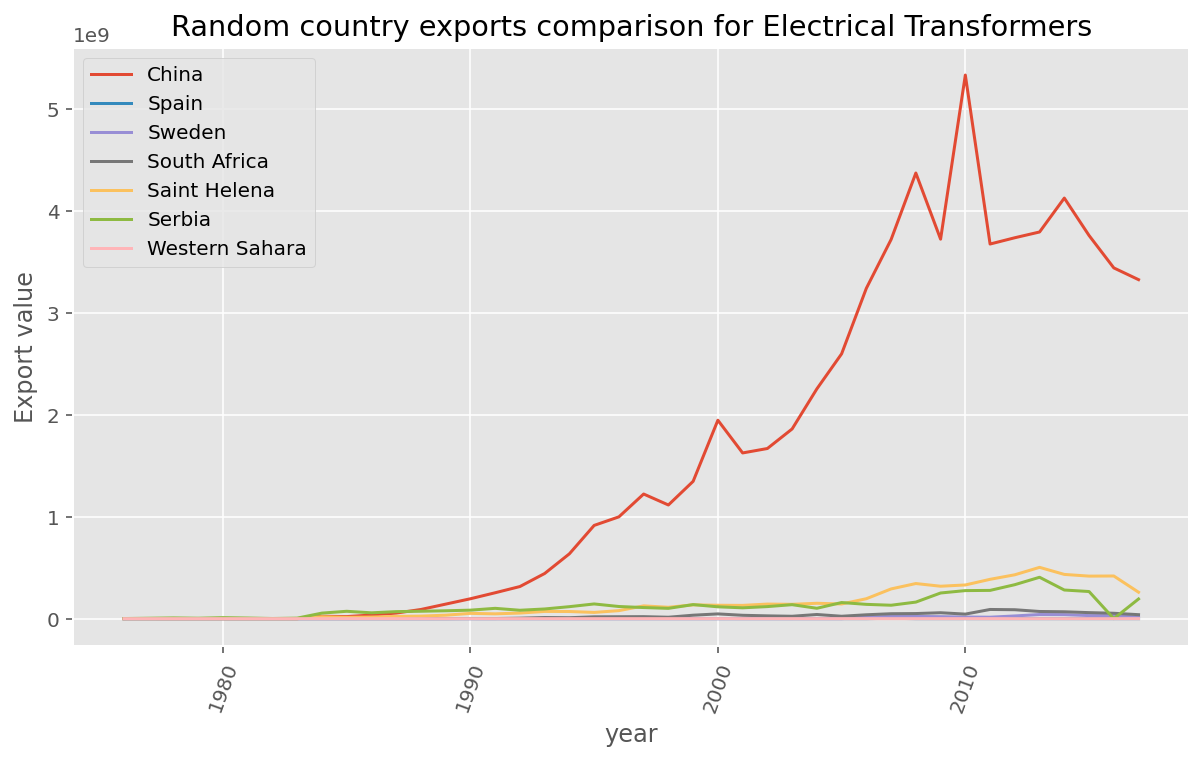

<Figure size 720x396 with 0 Axes>

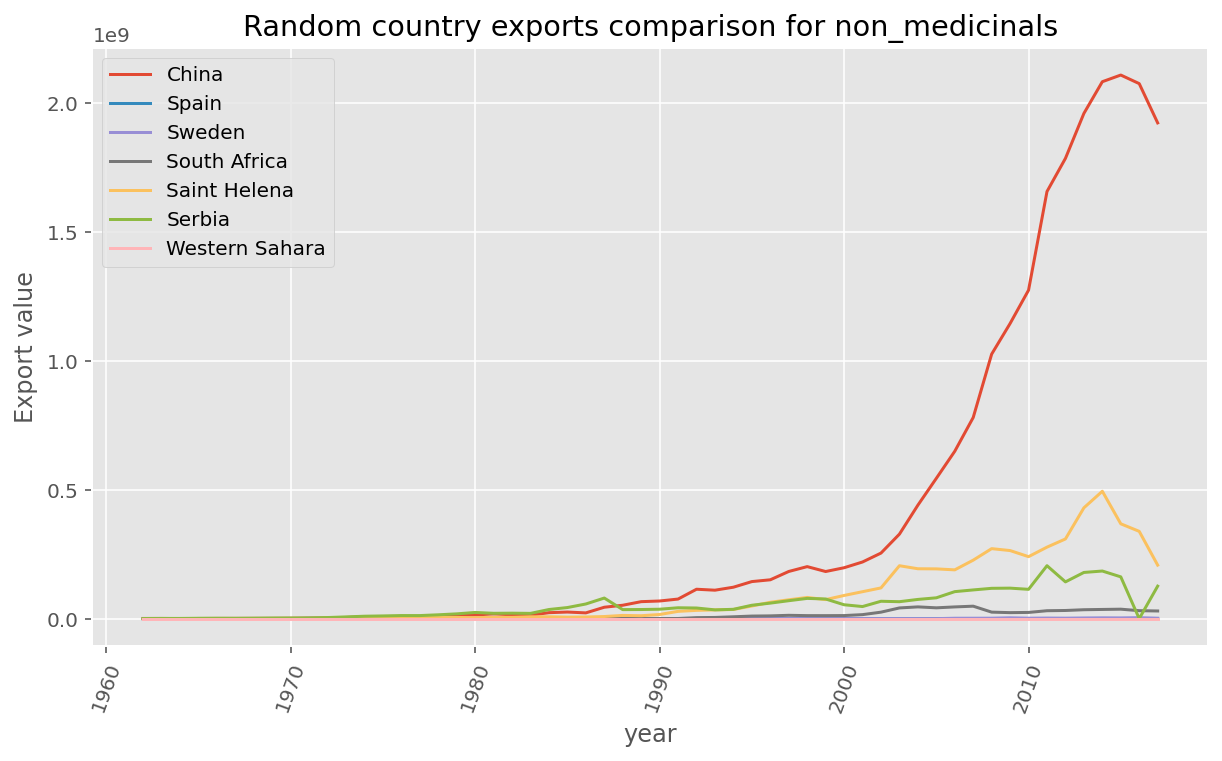

<Figure size 720x396 with 0 Axes>

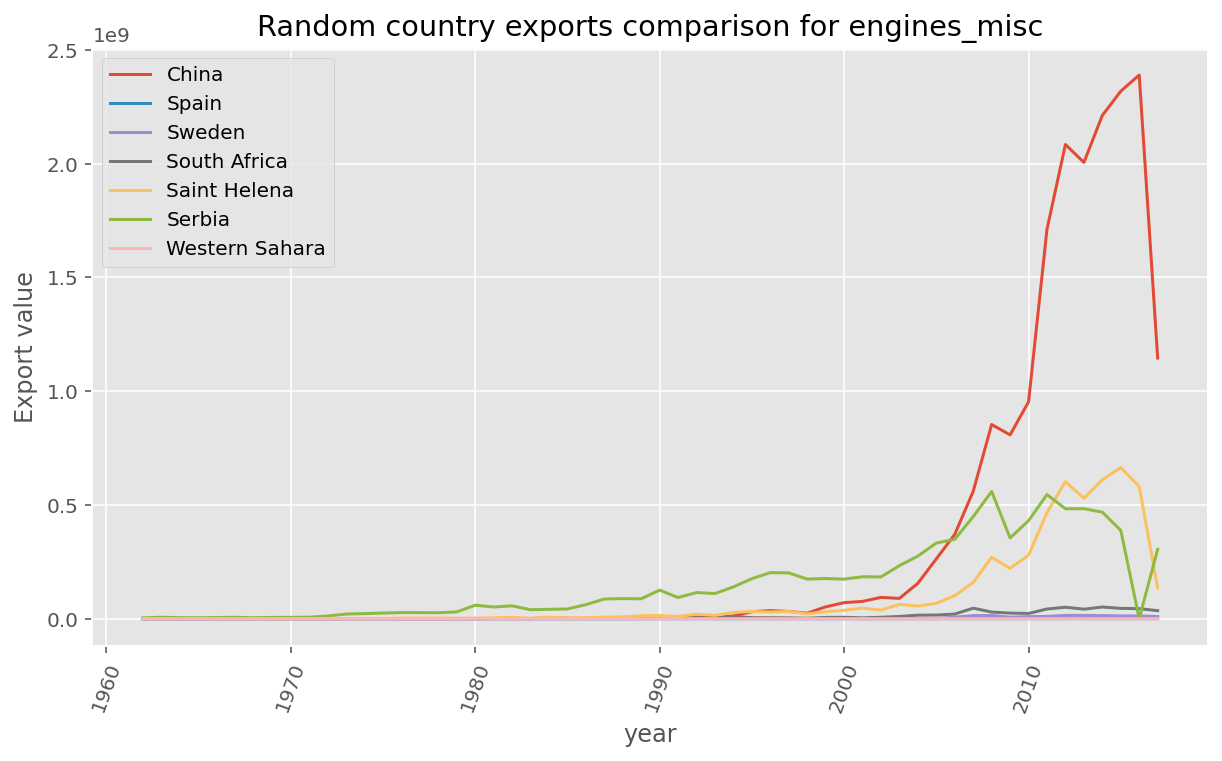

In [ ]:
random.seed(20)
random_countries = sample(list(agg_country.columns), 5)
random_countries.extend(['South Africa','China'])
countries = trade_dframe[trade_dframe['country'].isin(random_countries)]
for c in random_countries:
  agg_random_countries = pd.pivot_table(trade_dframe[trade_dframe.country==c], 
                                        index='year', columns='product_name', 
                                        values='export_val',
                                        aggfunc=np.mean)
  agg_random_countries.fillna(0,inplace=True)
  underscore_header_names(agg_random_countries)
  agg_random_countries.plot(subplots=False,figsize=(10,5.5),
                            title=f"Products in trade basket for {c}",sharey=True)
  plt.savefig(f"{c}_trade_basket")

# Plots for country comparison per product 
for id in trade_dframe.product_name.unique():
  product = pd.pivot_table(trade_dframe[trade_dframe.product_name==id], 
                           index='year', 
                           columns='country', 
                           values='export_val', 
                           aggfunc=np.mean)
  product.fillna(0,inplace=True)
  product.to_csv(f'{PATH}/products_per_country/{id}_sitc.csv')
  product_by_countries = pd.pivot_table(countries[countries.product_name==id], index='year', 
                           columns='country',values='export_val',aggfunc=np.mean)
  product_by_countries.fillna(0,inplace=True)
  plt.figure(figsize=(10,5.5))
  product_by_countries.plot(subplots=False,figsize=(10,5.5),
                            title=(f"Random country exports comparison for {id}"))
  plt.xticks(rotation=70)
  plt.ylabel("Export value")
  plt.legend(countries['country'].unique())
  plt.savefig(f"raw_{id}_country_comparison")
  plt.show()

## Rescale time series to the global mean for the product

Some random countries have no data, a fixed list will be plotted


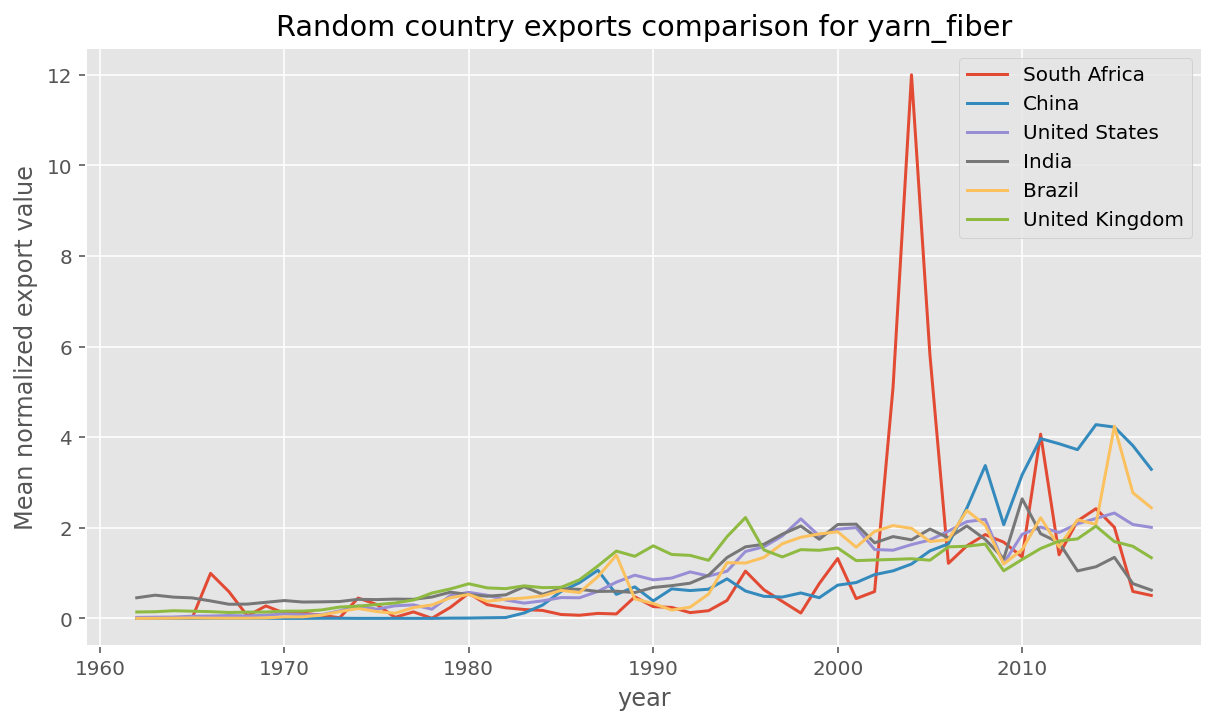

Some random countries have no data, a fixed list will be plotted


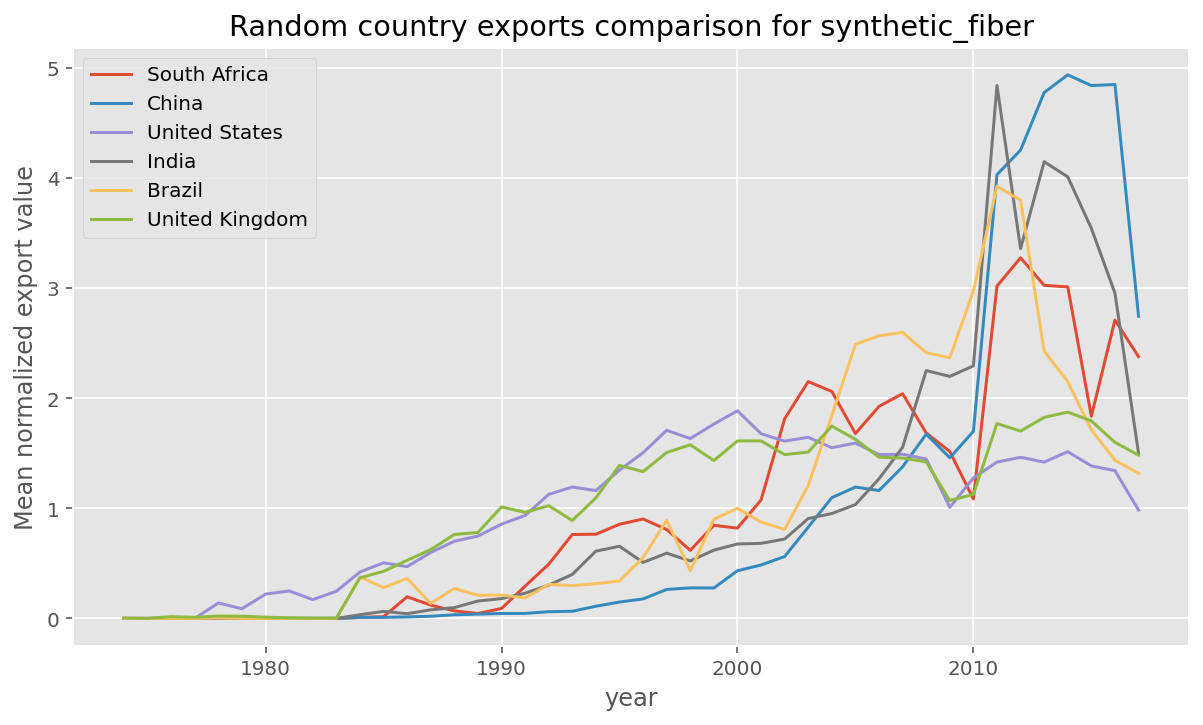

Some random countries have no data, a fixed list will be plotted


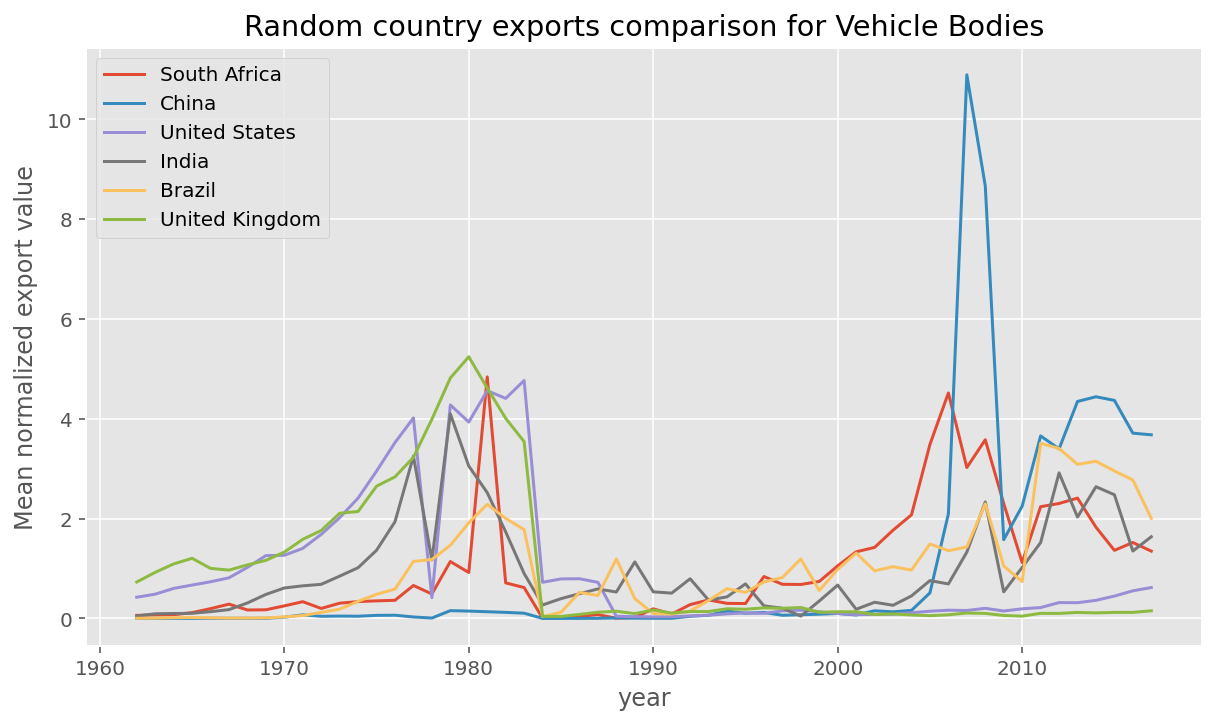

Some random countries have no data, a fixed list will be plotted


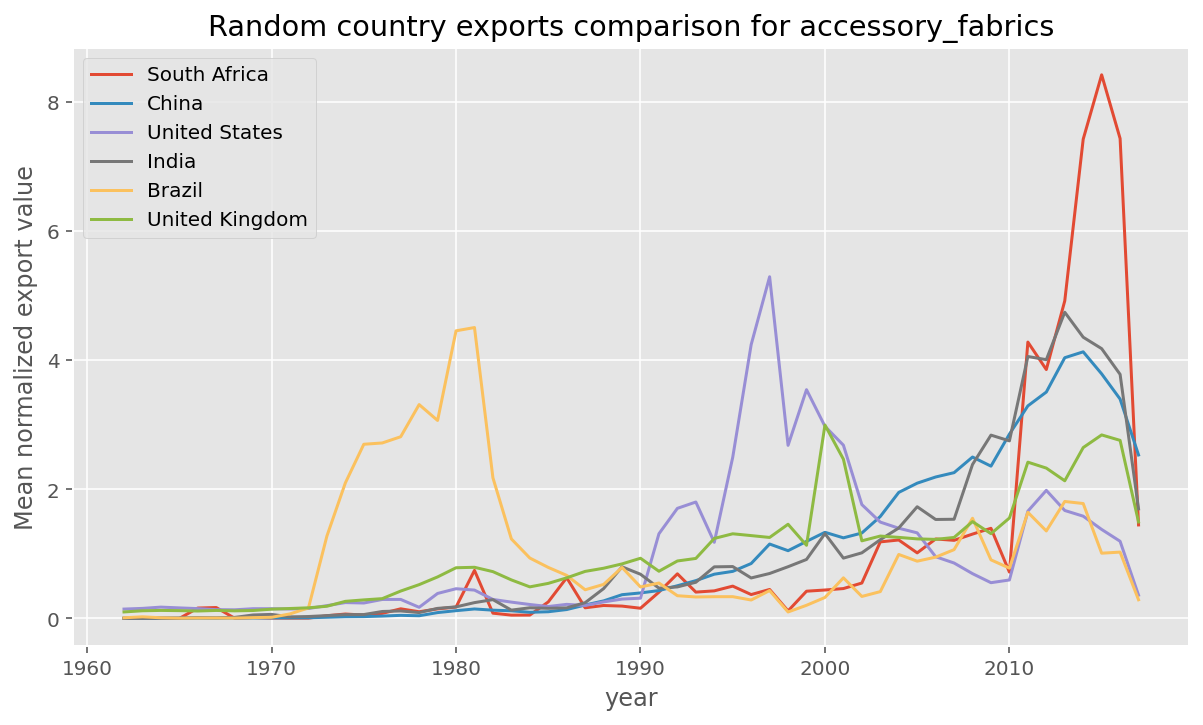

Some random countries have no data, a fixed list will be plotted


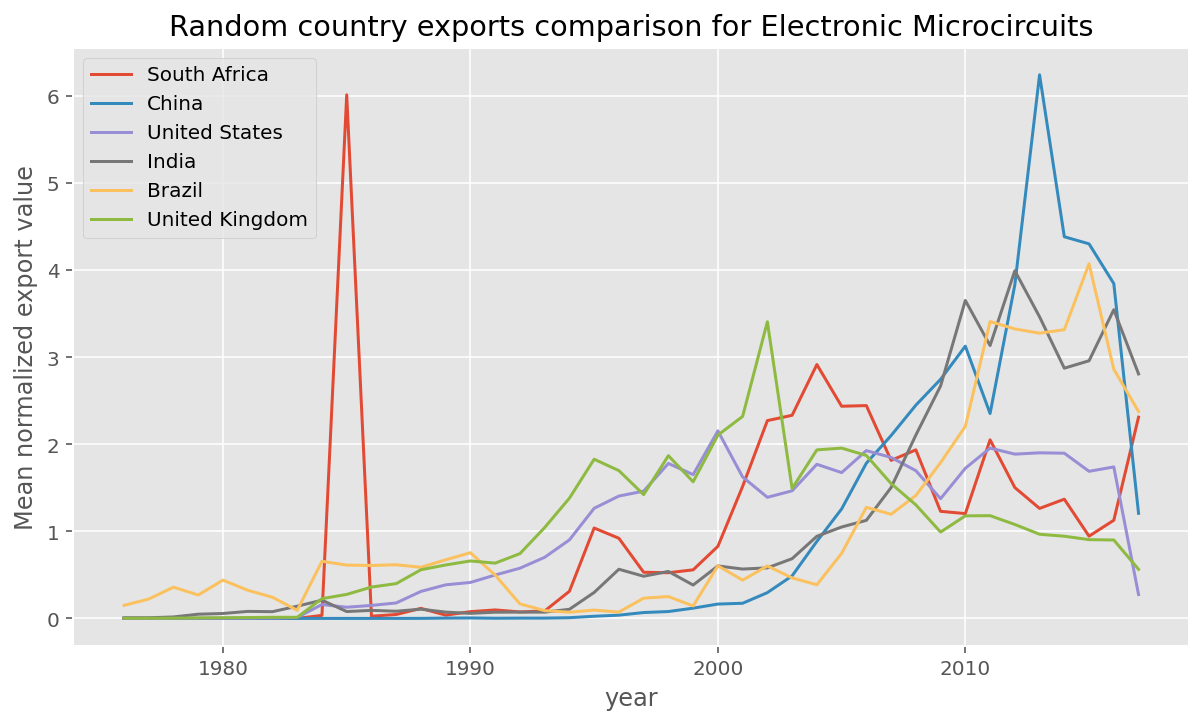

Some random countries have no data, a fixed list will be plotted


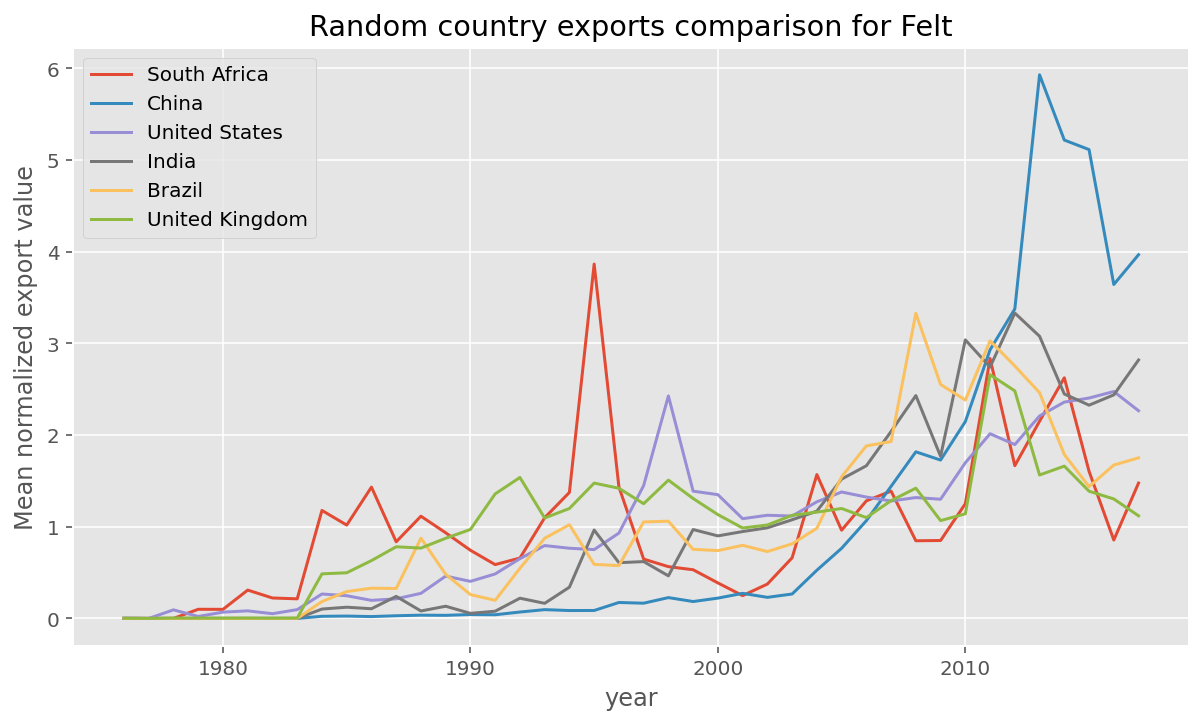

Some random countries have no data, a fixed list will be plotted


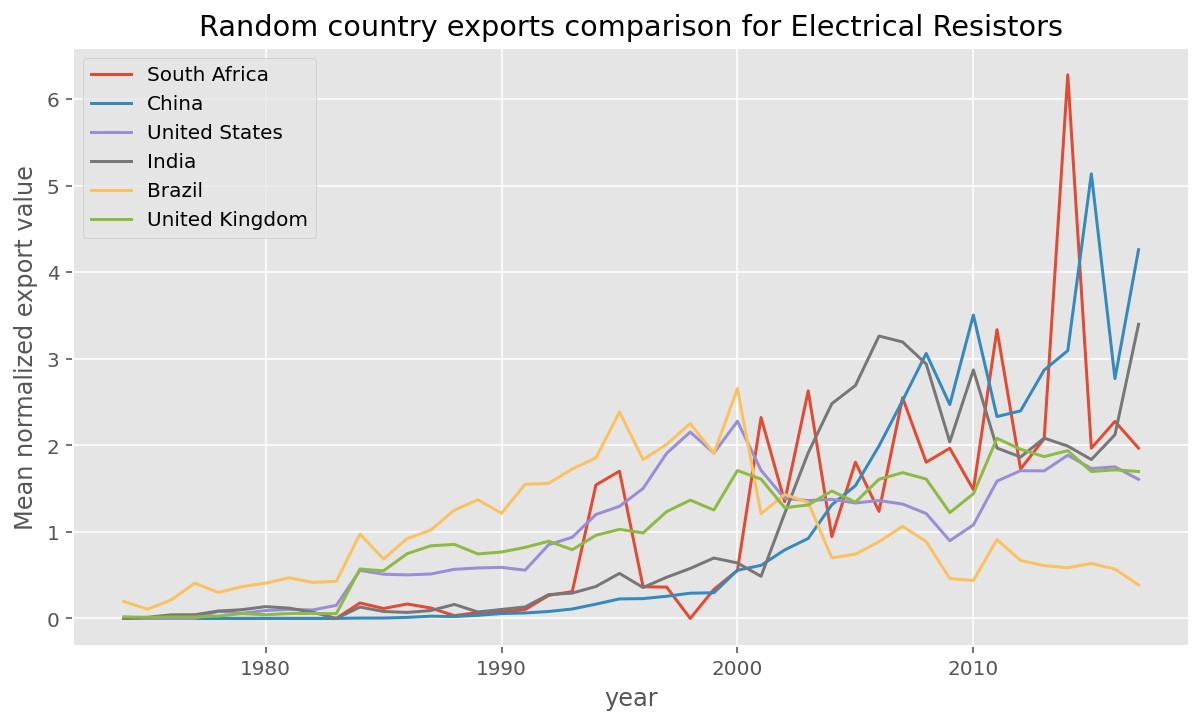

Some random countries have no data, a fixed list will be plotted


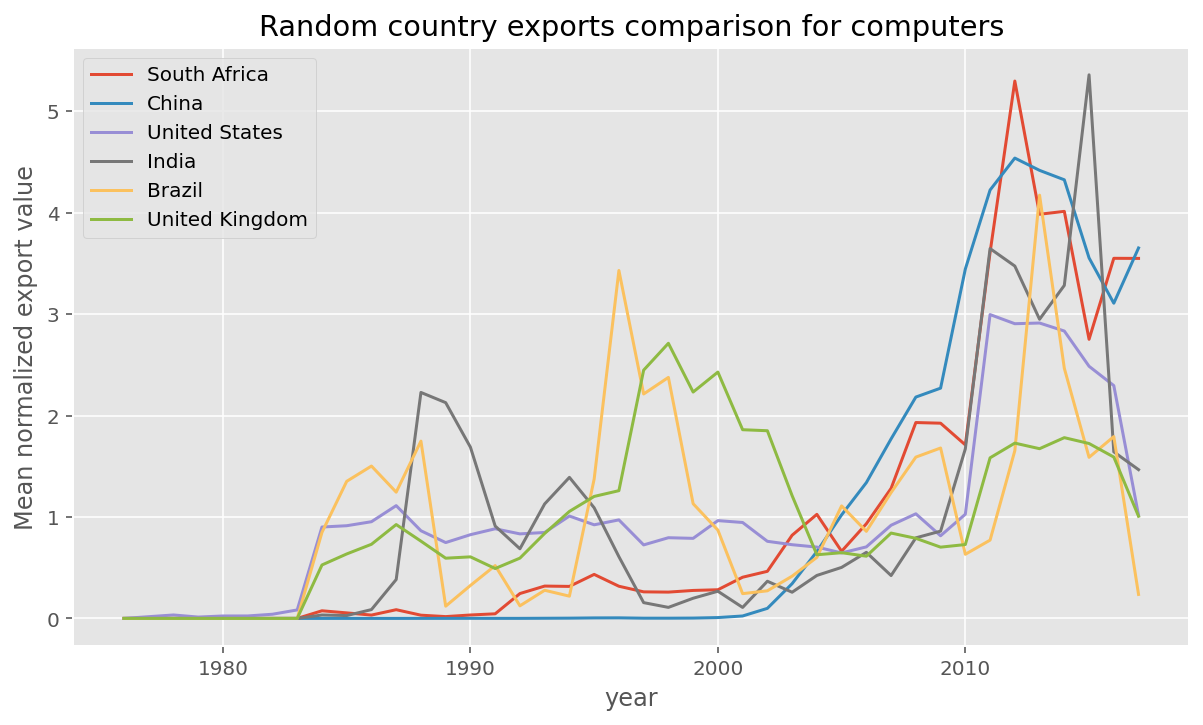

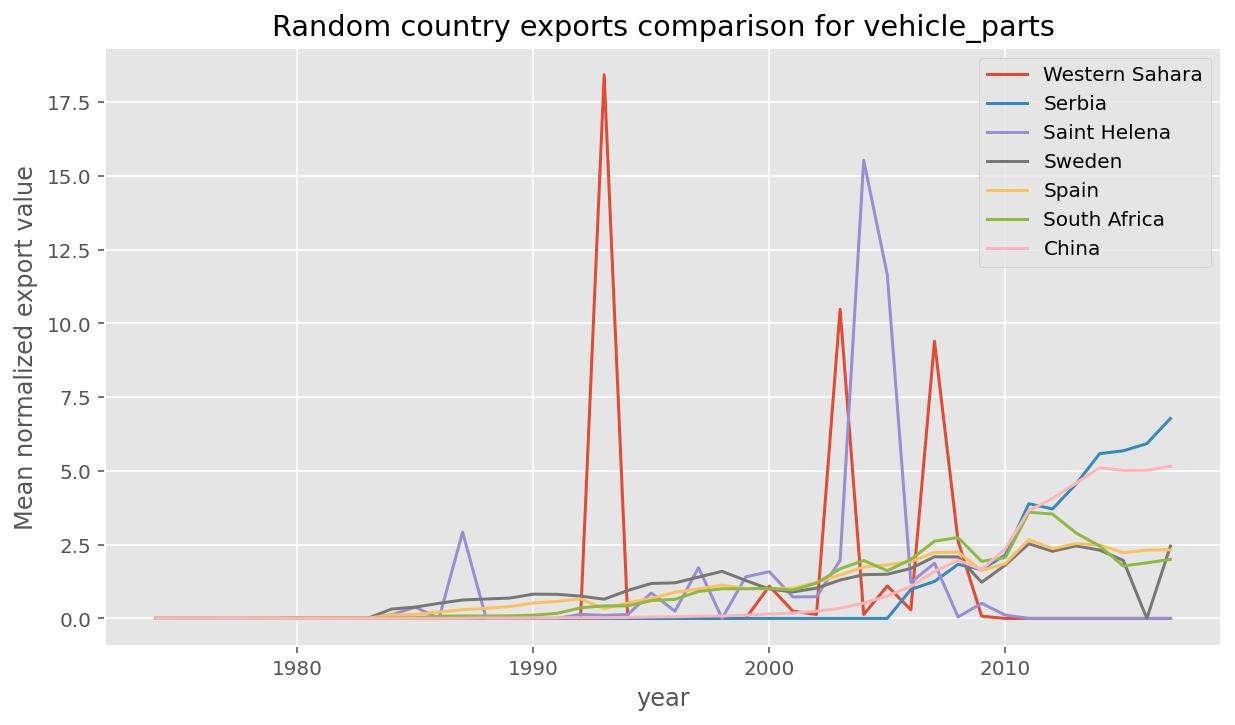

Some random countries have no data, a fixed list will be plotted


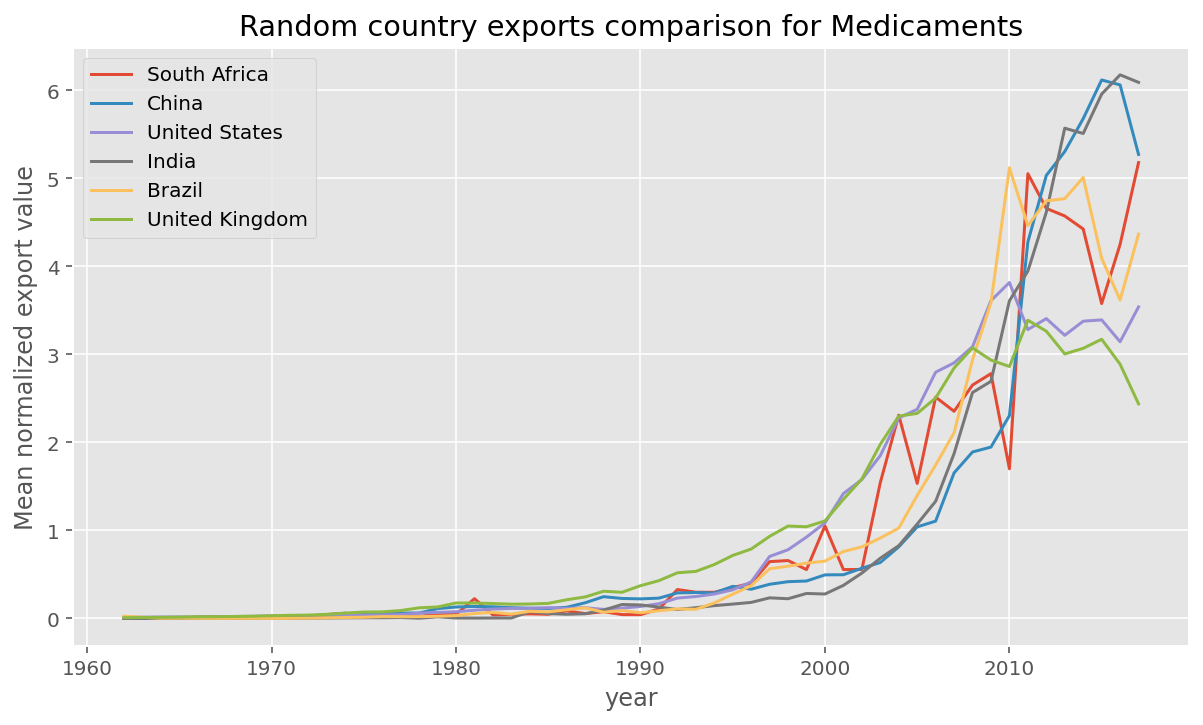

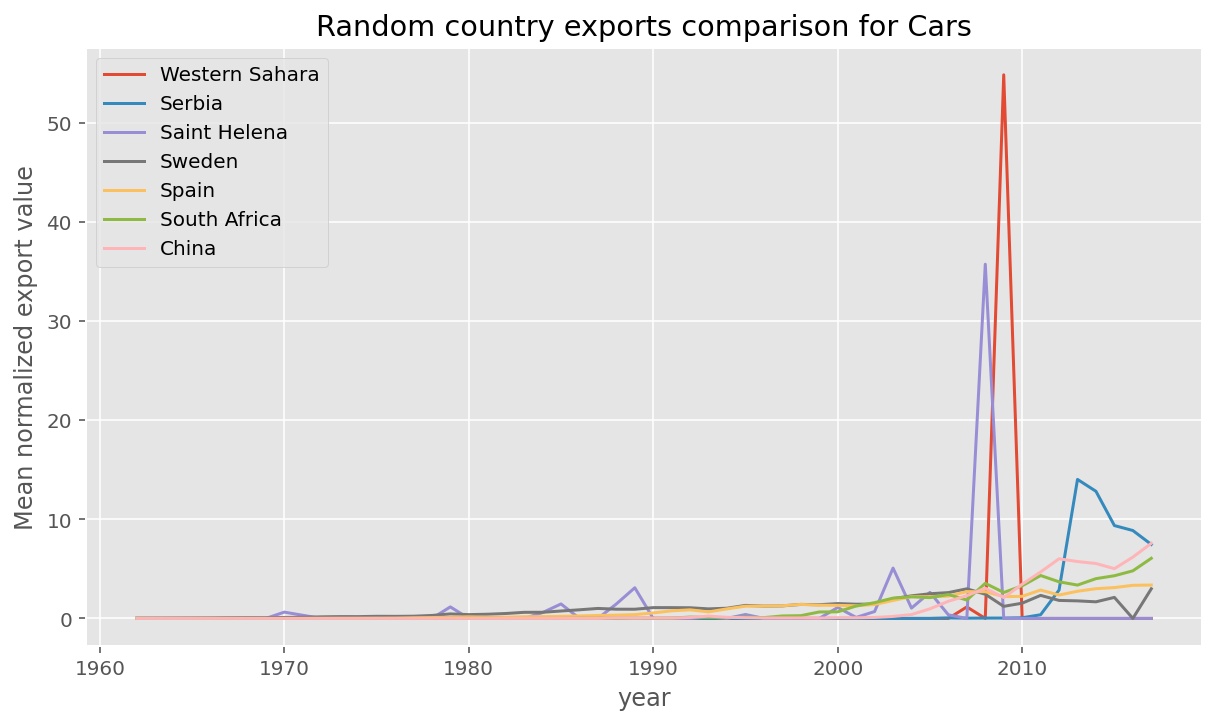

Some random countries have no data, a fixed list will be plotted


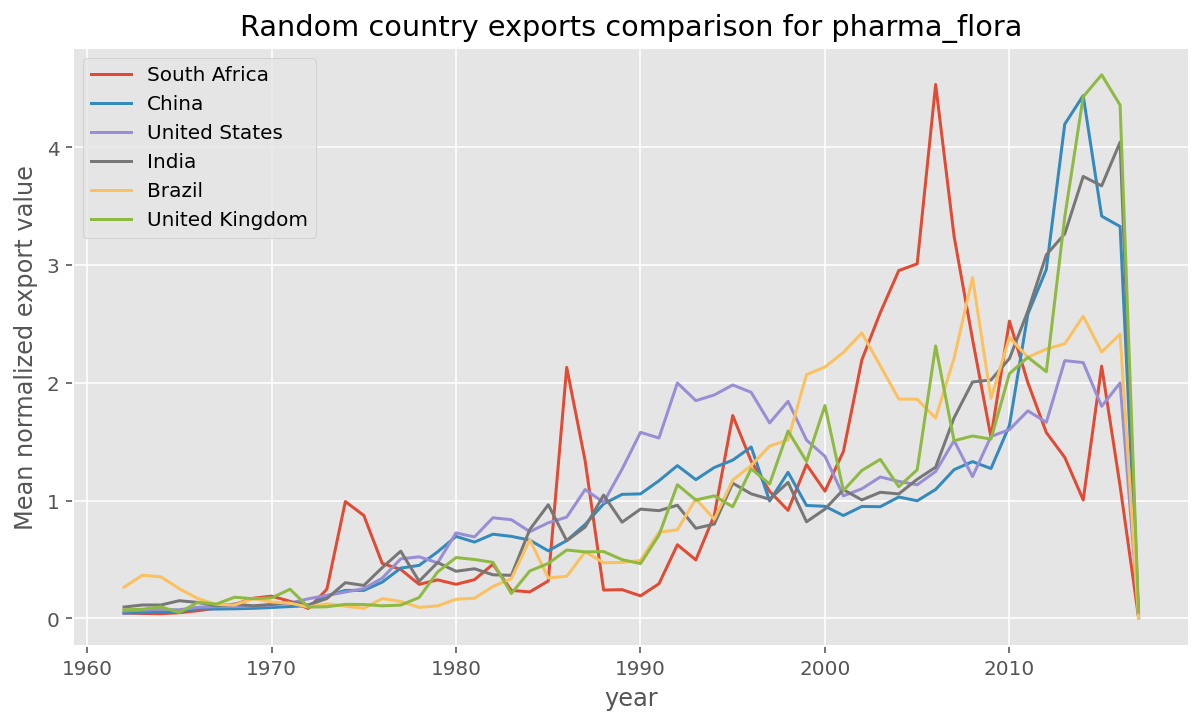

Some random countries have no data, a fixed list will be plotted


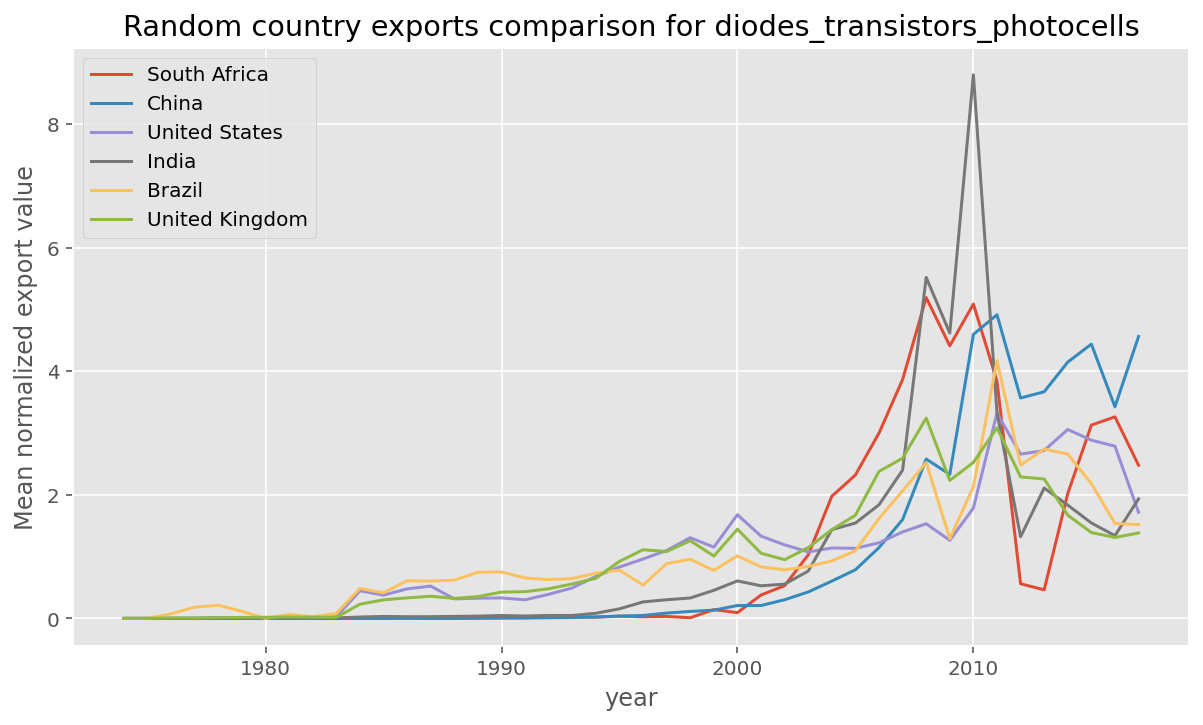

Some random countries have no data, a fixed list will be plotted


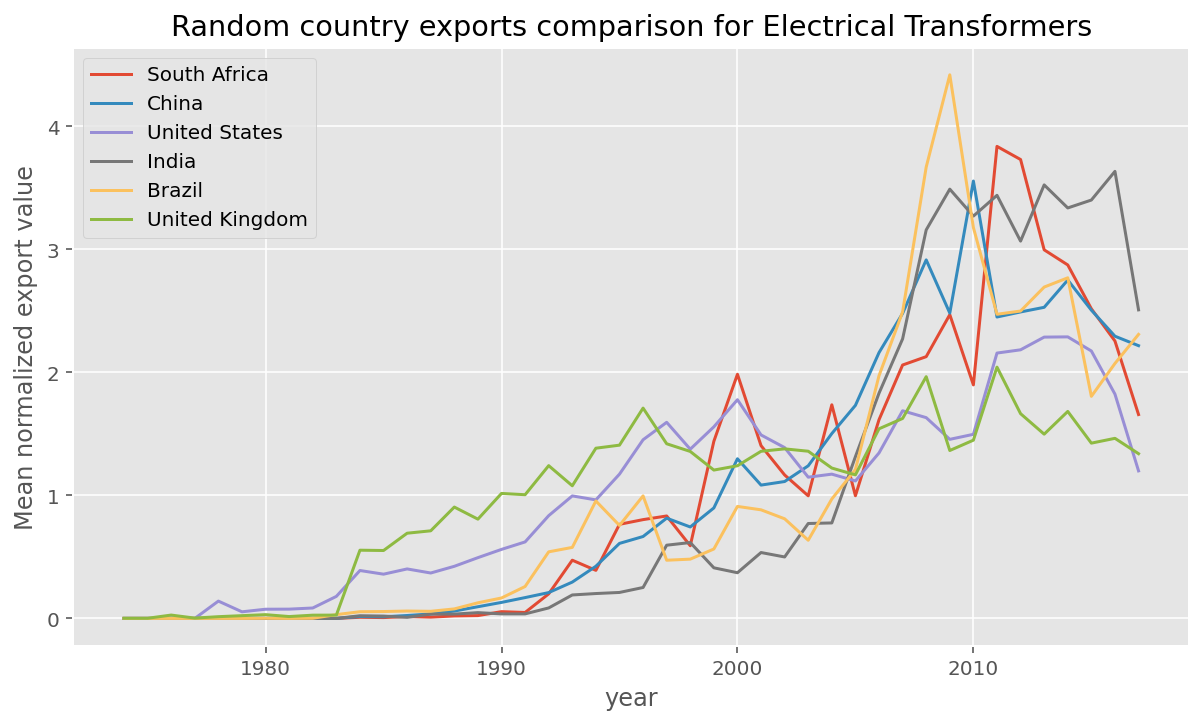

Some random countries have no data, a fixed list will be plotted


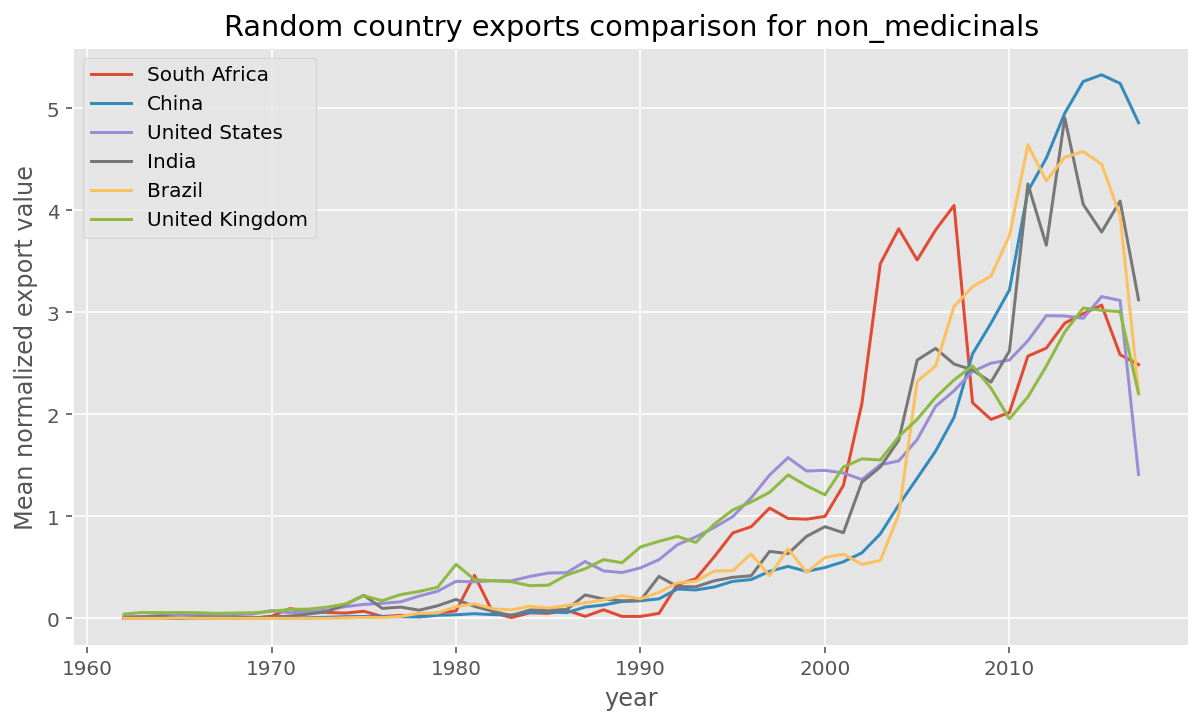

Some random countries have no data, a fixed list will be plotted


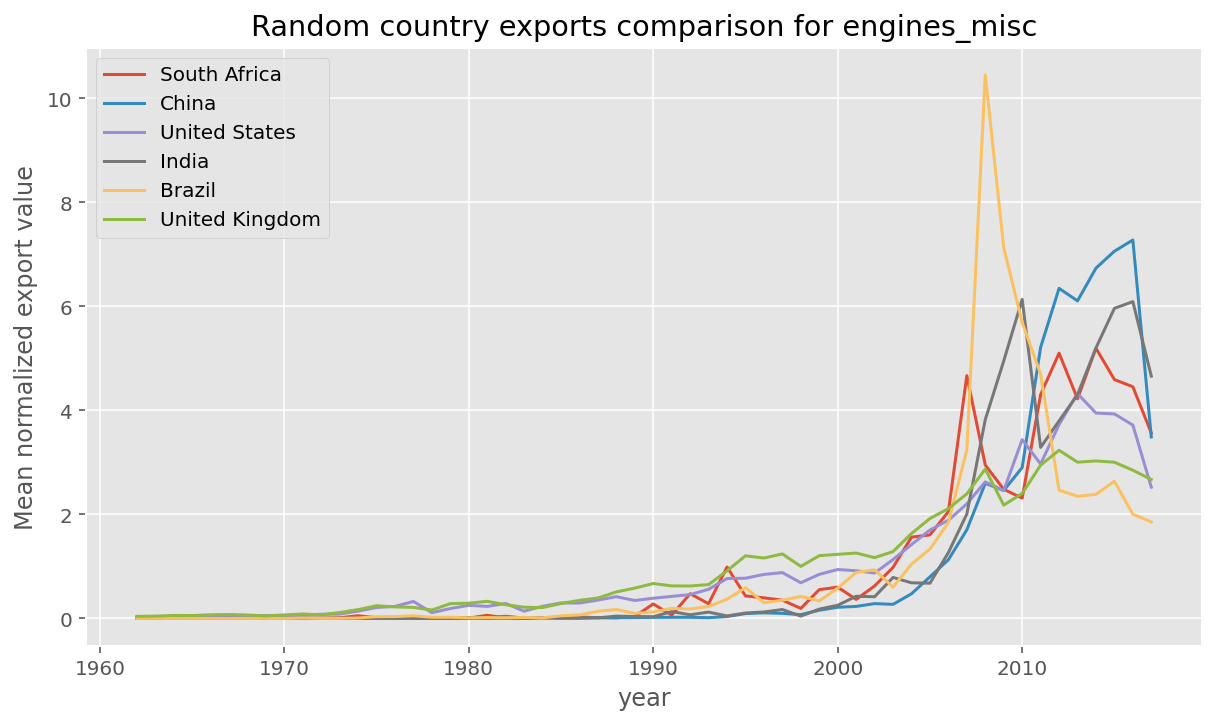

In [ ]:
fixed_random_list = ["South Africa","China","United States","India","Brazil","United Kingdom"]
for id in trade_dframe.product_name.unique():
  product = pd.pivot_table(trade_dframe[trade_dframe.product_name==id], 
                           index='year', 
                           columns='country', 
                           values='export_val', 
                           aggfunc=np.mean)
  remove_null_values(product)
  
  mean_scaled_product = product.div(product.mean(axis=0),axis=1)
  mean_scaled_product.to_csv(f'{PATH}/mean_scaled_products/mean_scaled_{id}.csv')
  try:
    product_by_countries = mean_scaled_product[random_countries]
  except:
    print("Some random countries have no data, a fixed list will be plotted")
    product_by_countries = mean_scaled_product.loc[:,fixed_random_list]
  product_by_countries.plot(subplots=False,figsize=(10,5.5),title=(f'Random country exports comparison for {id}'))
  plt.ylabel("Mean normalized export value")
  plt.legend(product_by_countries.columns)
  plt.savefig(f"{PATH}/images/{id}_normalized")
  plt.show()